In [ ]:
%run PNe_fitting

In [ ]:
%whos
%who_ls


In [1]:
gal_name = "FCC167"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils, wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
#from astropy.stats import knuth_bin_width, histogram, bayesian_blocks
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import PNe_residuals_3D, PNe_spectrum_extractor, PNextractor, PSF_residuals_3D, data_cube_y_x
from PNLF_new import open_data, reconstructed_image, completeness
import yaml
import sep
from photutils import CircularAperture
import scipy as sp
from scipy.stats import norm
from scipy import stats

%config InlineBackend.figure_format = 'retina'

In [3]:
# functions
# Open Fits file and assign to raw_data
# 

# if gal_name == "FCC167":
#     hdulist = fits.open("FCC167_data/FCC167_emission_cube.fits")
#     hdr = hdulist[0].header
#     wavelength = np.load(gal_name+"_data/"+gal_name+"_wavelength.npy")
# else:
#     hdulist = fits.open(gal_name+"_data/"+gal_name+"_residuals_list.fits")
#     hdr = hdulist[0].header
#     wavelength = np.exp(hdulist[1].data)

hdulist = fits.open(gal_name+"_data/"+gal_name+"_residuals_list.fits")
hdr = hdulist[0].header
wavelength = np.exp(hdulist[1].data)

if gal_name == "FCC219":
    x_data, y_data, n_data = data_cube_y_x(len(hdulist[0].data))
else:
    y_data, x_data, n_data = data_cube_y_x(len(hdulist[0].data))
    
    
n_pixels = 9    # minicube FOV in pixels
c = 299792458.0 # speed of light

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

# Retrieve the respective spectra for each PNe source

In [4]:
x_y_list = np.load("exported_data/"+gal_name+"/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

PNe_spectra = np.array([PNe_spectrum_extractor(x, y, n_pixels, hdulist[0].data, x_data, wave=wavelength) for x,y in zip(x_PNe, y_PNe)])

PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "V (km/s)", "m 5007", "M 5007", "[OIII] Flux", "M 5007 error","A/rN", "rad D", "redchi", "Filter"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers
PNe_df["Filter"] = "Y"

# Objective Residual Cube
obj_residual_cube = fits.open("exported_data/"+gal_name+"/resids_obj.fits")

# Data Residual Cube
data_residual_cube = fits.open("exported_data/"+gal_name+"/resids_data.fits")


def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    extract_data = np.array([PNe_spectrum_extractor(x, y, n_pix, data, x_data, wave=wavelength) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = np.abs(np.std(extract_data[p],1))
        array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

error_cube = uncertainty_cube_construct(data_residual_cube[0].data, x_PNe, y_PNe, n_pixels)
obj_error_cube = uncertainty_cube_construct(obj_residual_cube[0].data, x_PNe, y_PNe, n_pixels)

In [5]:
with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data, Loader=yaml.FullLoader)
    
galaxy_data = galaxy_info[gal_name]

emission_dict = galaxy_data["emissions"]

D = galaxy_data["Distance"]

z = galaxy_data["z"]

In [9]:
PNe_multi_params = Parameters()

def gen_params(wave=5007, FWHM=4.0, FWHM_err=0.1, beta=2.5, beta_err=0.3, LSF=2.81, em_dict=None, vary_LSF=False, vary_PSF=False):
    # loop through emission dictionary to add different element parameters 
    for em in em_dict:
        #Amplitude params for each emission
        PNe_multi_params.add('Amp_2D_{}'.format(em), value=emission_dict[em][0], min=0.001, max=1e5, expr=emission_dict[em][1])
        #Wavelength params for each emission
        if emission_dict[em][2] == None:
            PNe_multi_params.add("wave_{}".format(em), value=wave, min=wave-50., max=wave+50.)
        else:
            PNe_multi_params.add("wave_{}".format(em), expr=emission_dict[em][2].format(z))
    
    PNe_multi_params.add("x_0", value=((n_pixels//2.) +1), min=0.1, max=n_pixels)
    PNe_multi_params.add("y_0", value=((n_pixels//2.) +1), min=0.1, max=n_pixels)
    PNe_multi_params.add("LSF", value=LSF, vary=vary_LSF) #min=LSF-0.2, max=LSF+0.2,
    PNe_multi_params.add("M_FWHM", value=FWHM, min=FWHM - FWHM_err, max=FWHM + FWHM_err, vary=vary_PSF)
    PNe_multi_params.add("beta", value=beta, min=beta - beta_err, max=beta + beta_err, vary=vary_PSF)   
    PNe_multi_params.add("Gauss_bkg",  value=0.0001, vary=True)#1, min=-200, max=500)
    PNe_multi_params.add("Gauss_grad", value=0.0001, vary=True)#1, min=-2, max=2)
    
# storage setup
total_Flux = np.zeros((len(x_PNe),len(emission_dict)))
A_2D_list = np.zeros((len(x_PNe),len(emission_dict)))
F_xy_list = np.zeros((len(x_PNe), len(emission_dict), len(PNe_spectra[0])))
emission_amp_list = np.zeros((len(x_PNe),len(emission_dict)))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
mean_wave_list = np.zeros((len(x_PNe),len(emission_dict)))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
chi_2_r = np.zeros((len(x_PNe)))

# error lists
moff_A_err = np.zeros((len(x_PNe), len(emission_dict)))
x_0_err = np.zeros((len(x_PNe), len(emission_dict)))
y_0_err = np.zeros((len(x_PNe), len(emission_dict)))
mean_wave_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_bkg_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_grad_err = np.zeros((len(x_PNe), len(emission_dict)))

FWHM_list = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))


def log_10(x):
    return np.log10(x)

def run_minimiser(parameters):
    for PNe_num in np.arange(0, len(x_PNe)):
        useful_stuff = []        
        PNe_minimizer     = lmfit.Minimizer(PNe_residuals_3D,PNe_multi_params, fcn_args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, emission_dict, useful_stuff), nan_policy="propagate")
        multi_fit_results = PNe_minimizer.minimize()
        total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
        list_of_fit_residuals[PNe_num] = useful_stuff[0]
        A_2D_list[PNe_num]  = useful_stuff[1][0]
        F_xy_list[PNe_num]  = useful_stuff[1][1]
        model_spectra_list[PNe_num] = useful_stuff[1][3]
        emission_amp_list[PNe_num]  = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
        mean_wave_list[PNe_num]     = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]   
        chi_2_r[PNe_num]    = multi_fit_results.redchi
        list_of_x[PNe_num]  = multi_fit_results.params["x_0"]
        list_of_y[PNe_num]  = multi_fit_results.params["y_0"]
        Gauss_bkg[PNe_num]  = multi_fit_results.params["Gauss_bkg"]
        Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
        #save errors
        moff_A_err[PNe_num]     = [multi_fit_results.params["Amp_2D_{}".format(em)].stderr for em in emission_dict]
        mean_wave_err[PNe_num]  = [multi_fit_results.params["wave_{}".format(em)].stderr for em in emission_dict]
        x_0_err[PNe_num]        = multi_fit_results.params["x_0"].stderr
        y_0_err[PNe_num]        = multi_fit_results.params["y_0"].stderr
        Gauss_bkg_err[PNe_num]  = multi_fit_results.params["Gauss_bkg"].stderr
        Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr

    # Signal to noise and Magnitude calculations
    list_of_rN = np.array([np.std(PNe_res) for PNe_res in list_of_fit_residuals])
    PNe_df["A/rN"] = A_2D_list[:,0] / list_of_rN # Using OIII amplitude

    de_z_means = np.array(mean_wave_list[:,0] / (1 + z)) # de redshift OIII wavelength position
    
    PNe_df["V (km/s)"] = (c * (de_z_means - 5007.) / 5007.) / 1000.    
    
    PNe_df["redchi"] = chi_2_r
    
    PNe_df["[OIII] Flux"] = total_Flux[:,0] #store total OIII 5007 line flux
        
    if "hb" in emission_dict:
        PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store [OIII]/Hb ratio

    if "ha" in emission_dict:
        PNe_df["Ha Flux"] = total_Flux[:, 1]
    
    PNe_df["m 5007"] = -2.5 * np.log10(PNe_df["[OIII] Flux"].values) - 13.74
    #dM =  5. * np.log10(D) + 25.
    #PNe_df["M 5007"] = PNe_df["m 5007"] - dM
    
    #Dist_est = 10.**(((PNe_df["m 5007"].min() + 4.47) -25.) / 5.)
    #print("Distance Estimate from PNLF: ", Dist_est, "Mpc")
    
    #dM =  5. * np.log10(Dist_est) + 25.   
    #PNe_df["M 5007"] = PNe_df["m 5007"] - dM


In [10]:
# star FCC219
#%pdb
print("Running fitter")
gen_params(wave=5007.*(1+z), FWHM=galaxy_data["FWHM"], beta=galaxy_data["beta"], LSF=galaxy_data["LSF"], em_dict=emission_dict, vary_LSF=False, vary_PSF=False)
run_minimiser(PNe_multi_params)
#display(PNe_df.loc[PNe_df["PNe number"]==32])
#plt.hist(PNe_df["m 5007"])

Running fitter


## The Great Filter

149


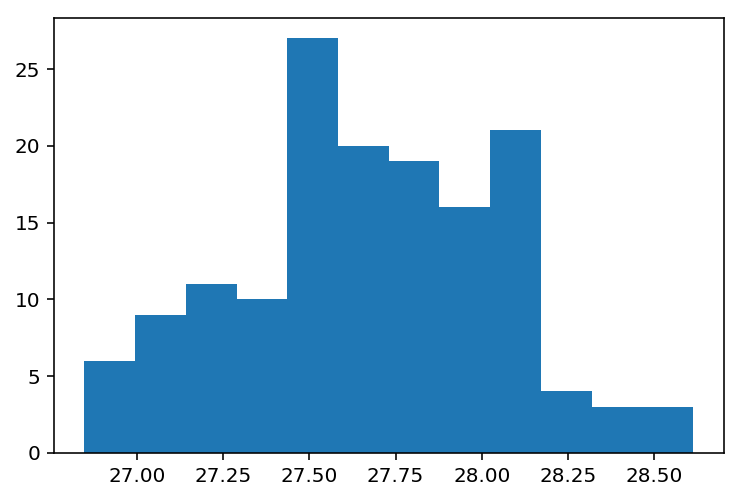

In [12]:
PNe_df.loc[PNe_df["m 5007"]>30, "Filter"] = "N"
PNe_df.loc[PNe_df["A/rN"]<2.5, "Filter"] = "N"

## FCC167
if gal_name == "FCC167":
    PNe_df.loc[PNe_df["PNe number"]==44, "Filter"] = "N" # Over luminous [OIII] source
    PNe_df.loc[PNe_df["PNe number"]==25, "Filter"] = "N" # SNR maybe, extended source with dual peaked [OIII] 5007
    PNe_df.loc[PNe_df["PNe number"]==126, "Filter"] = "N" # SNR maybe, extended source
## FCC219
#elif gal_name == "FCC219":
    # Put filtered out objects here
    

print(len(PNe_df["Filter"].loc[PNe_df["Filter"]=="Y"]))
plt.hist(PNe_df["m 5007"].loc[PNe_df["Filter"]=="Y"], bins=12);
plt.show()

# Error analysis

In [13]:
def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
def error_sim(n_sim, n_PNe):
    mean_flux = np.ones(n_PNe)
    flux_err  = np.ones(n_PNe)
    for n in np.arange(0,n_PNe):
        Moff_A_dist = np.random.normal(emission_amp_list[n][0], moff_A_err[n][0],n_sim)
        FWHM_dist = np.random.normal(galaxy_data["FWHM"], galaxy_data["FWHM_err"], n_sim)
        beta_dist = np.random.normal(galaxy_data["beta"], galaxy_data["beta_err"], n_sim)
        x_0_dist = np.random.normal(list_of_x[n], x_0_err[n][0], n_sim)
        y_0_dist = np.random.normal(list_of_y[n], y_0_err[n][0], n_sim)
        
        flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
        
        mean_flux[n], flux_err[n] = norm.fit(flux_array)
        
        #mu_m, std_m = norm.fit(-2.5*np.log10(flux_array)-13.72)

    return mean_flux, flux_err

mean_flux, PNe_df["Flux error"] = error_sim(10000, len(x_PNe))

## Show F_err in percentage terms
PNe_df["F[OIII] err percent"] = (PNe_df["Flux error"] / PNe_df["[OIII] Flux"])*100

## Distance estimate with error

In [14]:

p_n = int(PNe_df.loc[PNe_df["Filter"]=="Y"].nsmallest(1, "m 5007").index.values)
flux = PNe_df["[OIII] Flux"].iloc[p_n]
print(flux)
flux_err = PNe_df["Flux error"].iloc[p_n]

m = -2.5 * np.log10(flux) - 13.74
m_plus = -2.5 * np.log10(flux  + flux_err) - 13.74
m_minus = -2.5 * np.log10(flux - flux_err) - 13.74

Dist_est = 10.**(((m + 4.47) -25.) / 5.)
dist_diff_p = 10.**(((m_plus + 4.47) -25.) / 5.)
print("Lower: ", dist_diff_p)
dist_diff_m = 10.**(((m_minus + 4.47) -25.) / 5.)
print("Upper: ", dist_diff_m)
print("Distance Estimate from PNLF: ", Dist_est, "Mpc, +/-", np.median((Dist_est- dist_diff_p, dist_diff_m -Dist_est)),"Mpc")

5.820779812381855e-17
Lower:  18.045032201052575
Upper:  18.659704251780383
Distance Estimate from PNLF:  18.344649332920238 Mpc, +/- 0.30733602536390414 Mpc


In [15]:
dM =  5. * np.log10(Dist_est) + 25.
dM_lower = 5. * np.log10(17.980556687118906) + 25.
dM_upper = 5. * np.log10(18.602571894774417) + 25.

print(dM,"+", dM_upper-dM, "-", dM - dM_lower)

31.317547072083357 + 0.030317886235387448 - 0.04353140417371293


## M 5007 calculation from distance estimate

In [16]:
PNe_df["M 5007"] = PNe_df["m 5007"] - dM

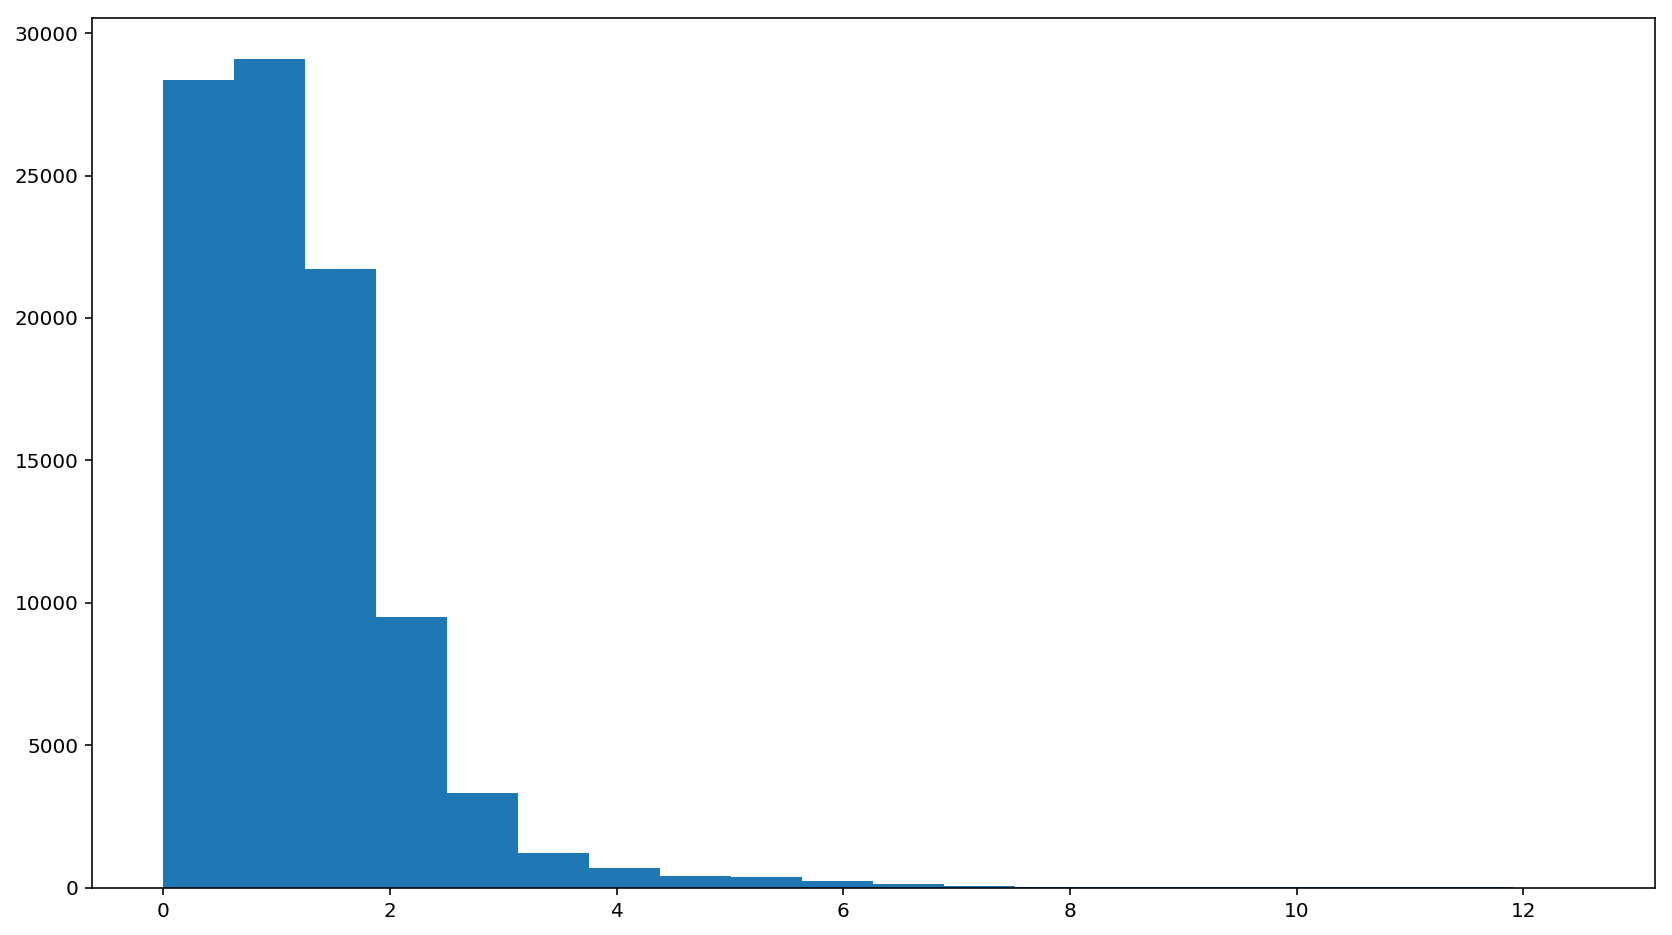

In [21]:
plt.figure(figsize=(14,8))
plt.hist(A_rN_plot, bins=20);


-67.36992349983561 133.7999156618502


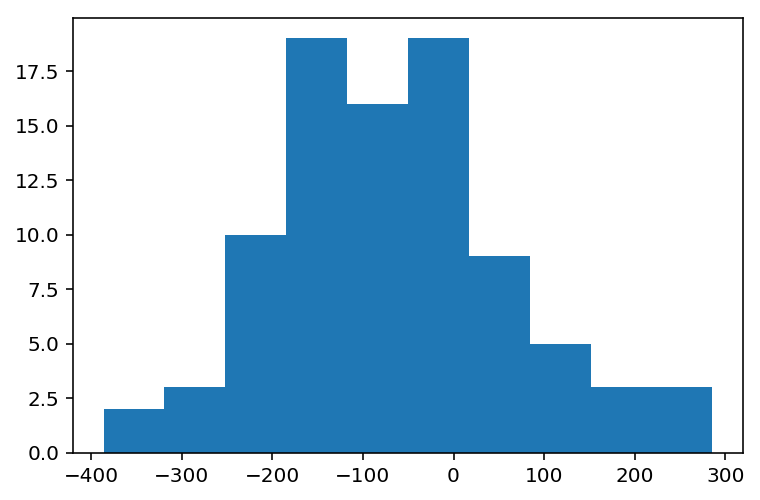

In [24]:
plt.hist(PNe_df["V (km/s)"],bins=10)
mu, std = norm.fit(PNe_df["V (km/s)"])
print(mu, std)

(0, 30)

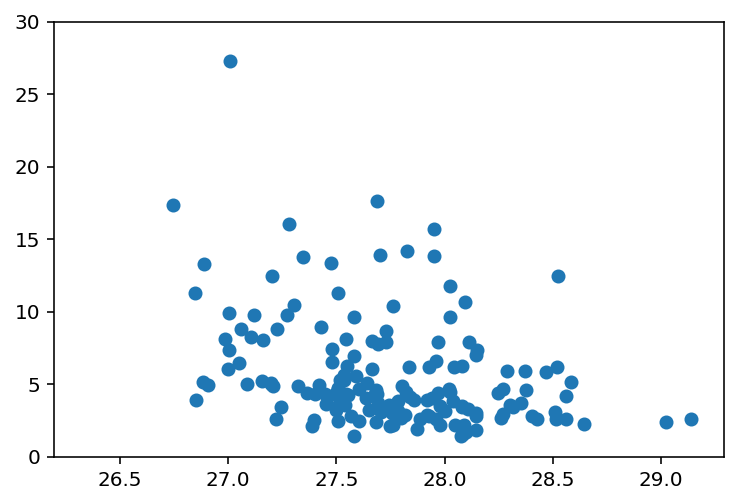

In [24]:
plt.scatter(PNe_df["m 5007"], PNe_df["[OIII]/Hb"])
plt.ylim(0,30)

## Pixel array size experiment

In [ ]:
# n_pix_dist = 31
n_range = np.arange(11,22,2)
store_here = np.ones(len(n_range))
for i, n_pix_dist in enumerate(n_range):
    coordinates = [(n,m) for n in range(n_pix_dist) for m in range(n_pix_dist)]
    x_fit = np.array([item[0] for item in coordinates])
    y_fit = np.array([item[1] for item in coordinates])
    
    n_sim = 10000
    Moff_A_dist = np.random.normal(emission_amp_list[40][0], moff_A_err[40][0],n_sim)
    FWHM_dist = np.random.normal(4.06, 0.018, n_sim)
    beta_dist = np.random.normal(3.41, 0.167, n_sim)
    x_0_dist = np.random.normal(list_of_x[40], x_0_err[40][0], n_sim)
    y_0_dist = np.random.normal(list_of_y[40], y_0_err[40][0], n_sim)
    
    def Moffat_err(Moff_A, FWHM, beta, x_0, y_0):
        gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
        rr_gg = ((np.array(x_fit) - x_0)**2 + (np.array(y_fit) - y_0)**2) / gamma**2
        F_OIII_xy_dist = Moff_A * (1 + rr_gg)**(-beta)
    
    
        return np.sum(F_OIII_xy_dist*1e-20)
    
    flux_array = [Moffat_err(Moff_A_dist[i], FWHM_dist[i], beta_dist[i], x_0_dist[i], y_0_dist[i]) for i in range(0,n_sim)]
    plt.hist(flux_array)
    plt.axvline(PNe_df["[OIII] Flux"].iloc[40])
#     plt.xlim(3.6e-17, 4.2e-17)
    #print(PNe_df["[OIII] Flux"].iloc[40])
    #print(PNe_df["m 5007"].iloc[40])
    mu_f, std_f = norm.fit(flux_array)
    #print(mu, (std/mu)*100,"%")
    plt.axvline(mu_f, c="r")
    
    mu, std = norm.fit(-2.5*np.log10(flux_array)-13.72)
    #print(mu, std)
    store_here[i] = mu_f

print(np.abs((-2.5*np.log10(store_here.max()) - 13.74)  -  (-2.5*np.log10(store_here[1]) - 13.74)))

plt.figure()
plt.plot(n_range, store_here)
plt.axvline(n_pixels)
# Correction for n_pixel and flux variation from fit

## Integrated spectrum with fit

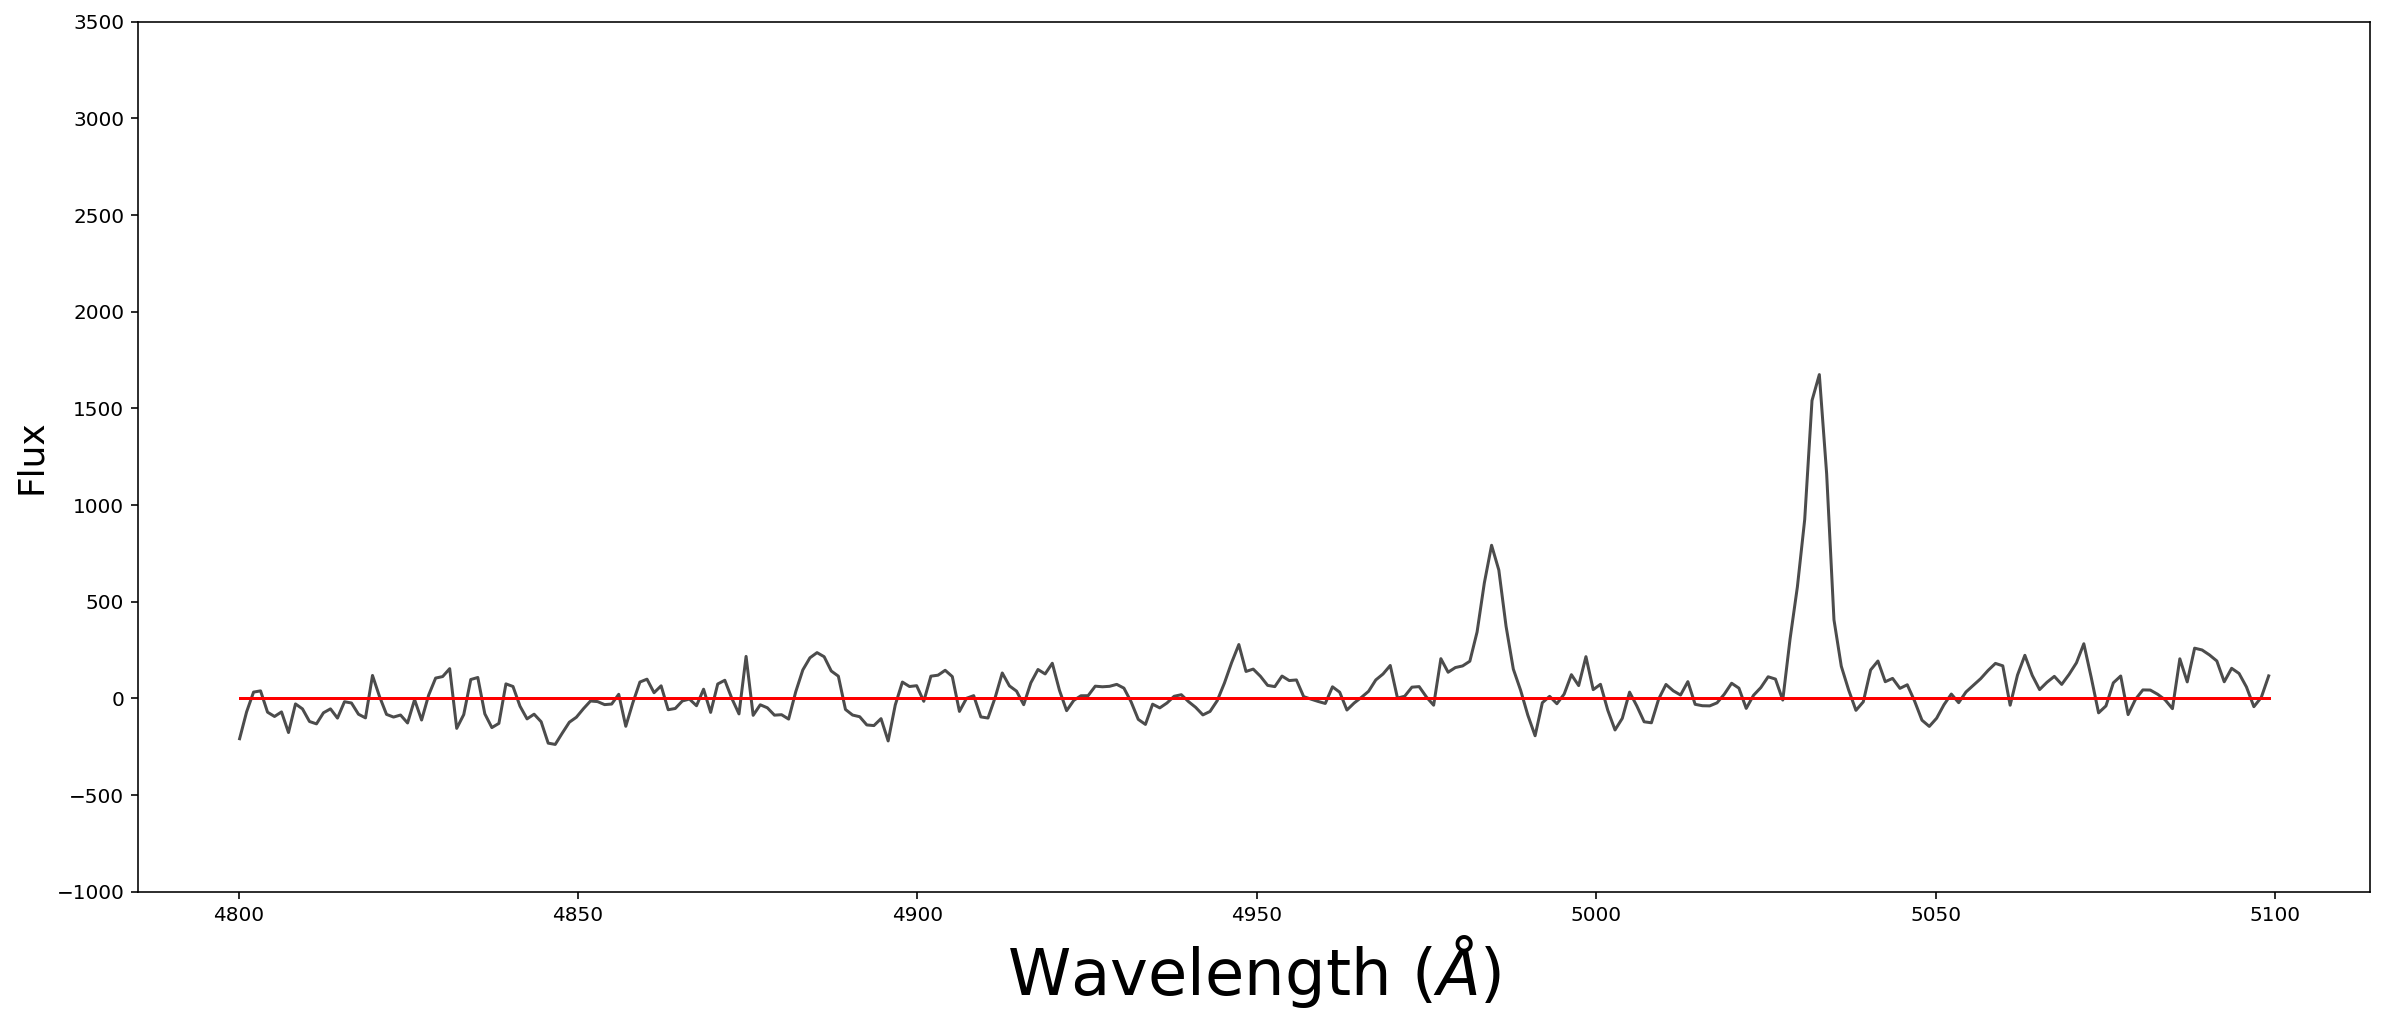

In [8]:
p = 174
plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k")

plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=32)
plt.ylabel("Flux", fontsize=18);
plt.ylim(-1000,3500);
#plt.axvline(5042)
#plt.xlim(4900,5100)
# plt.axvline(5033)

## Spaxel by spaxel with individual fits

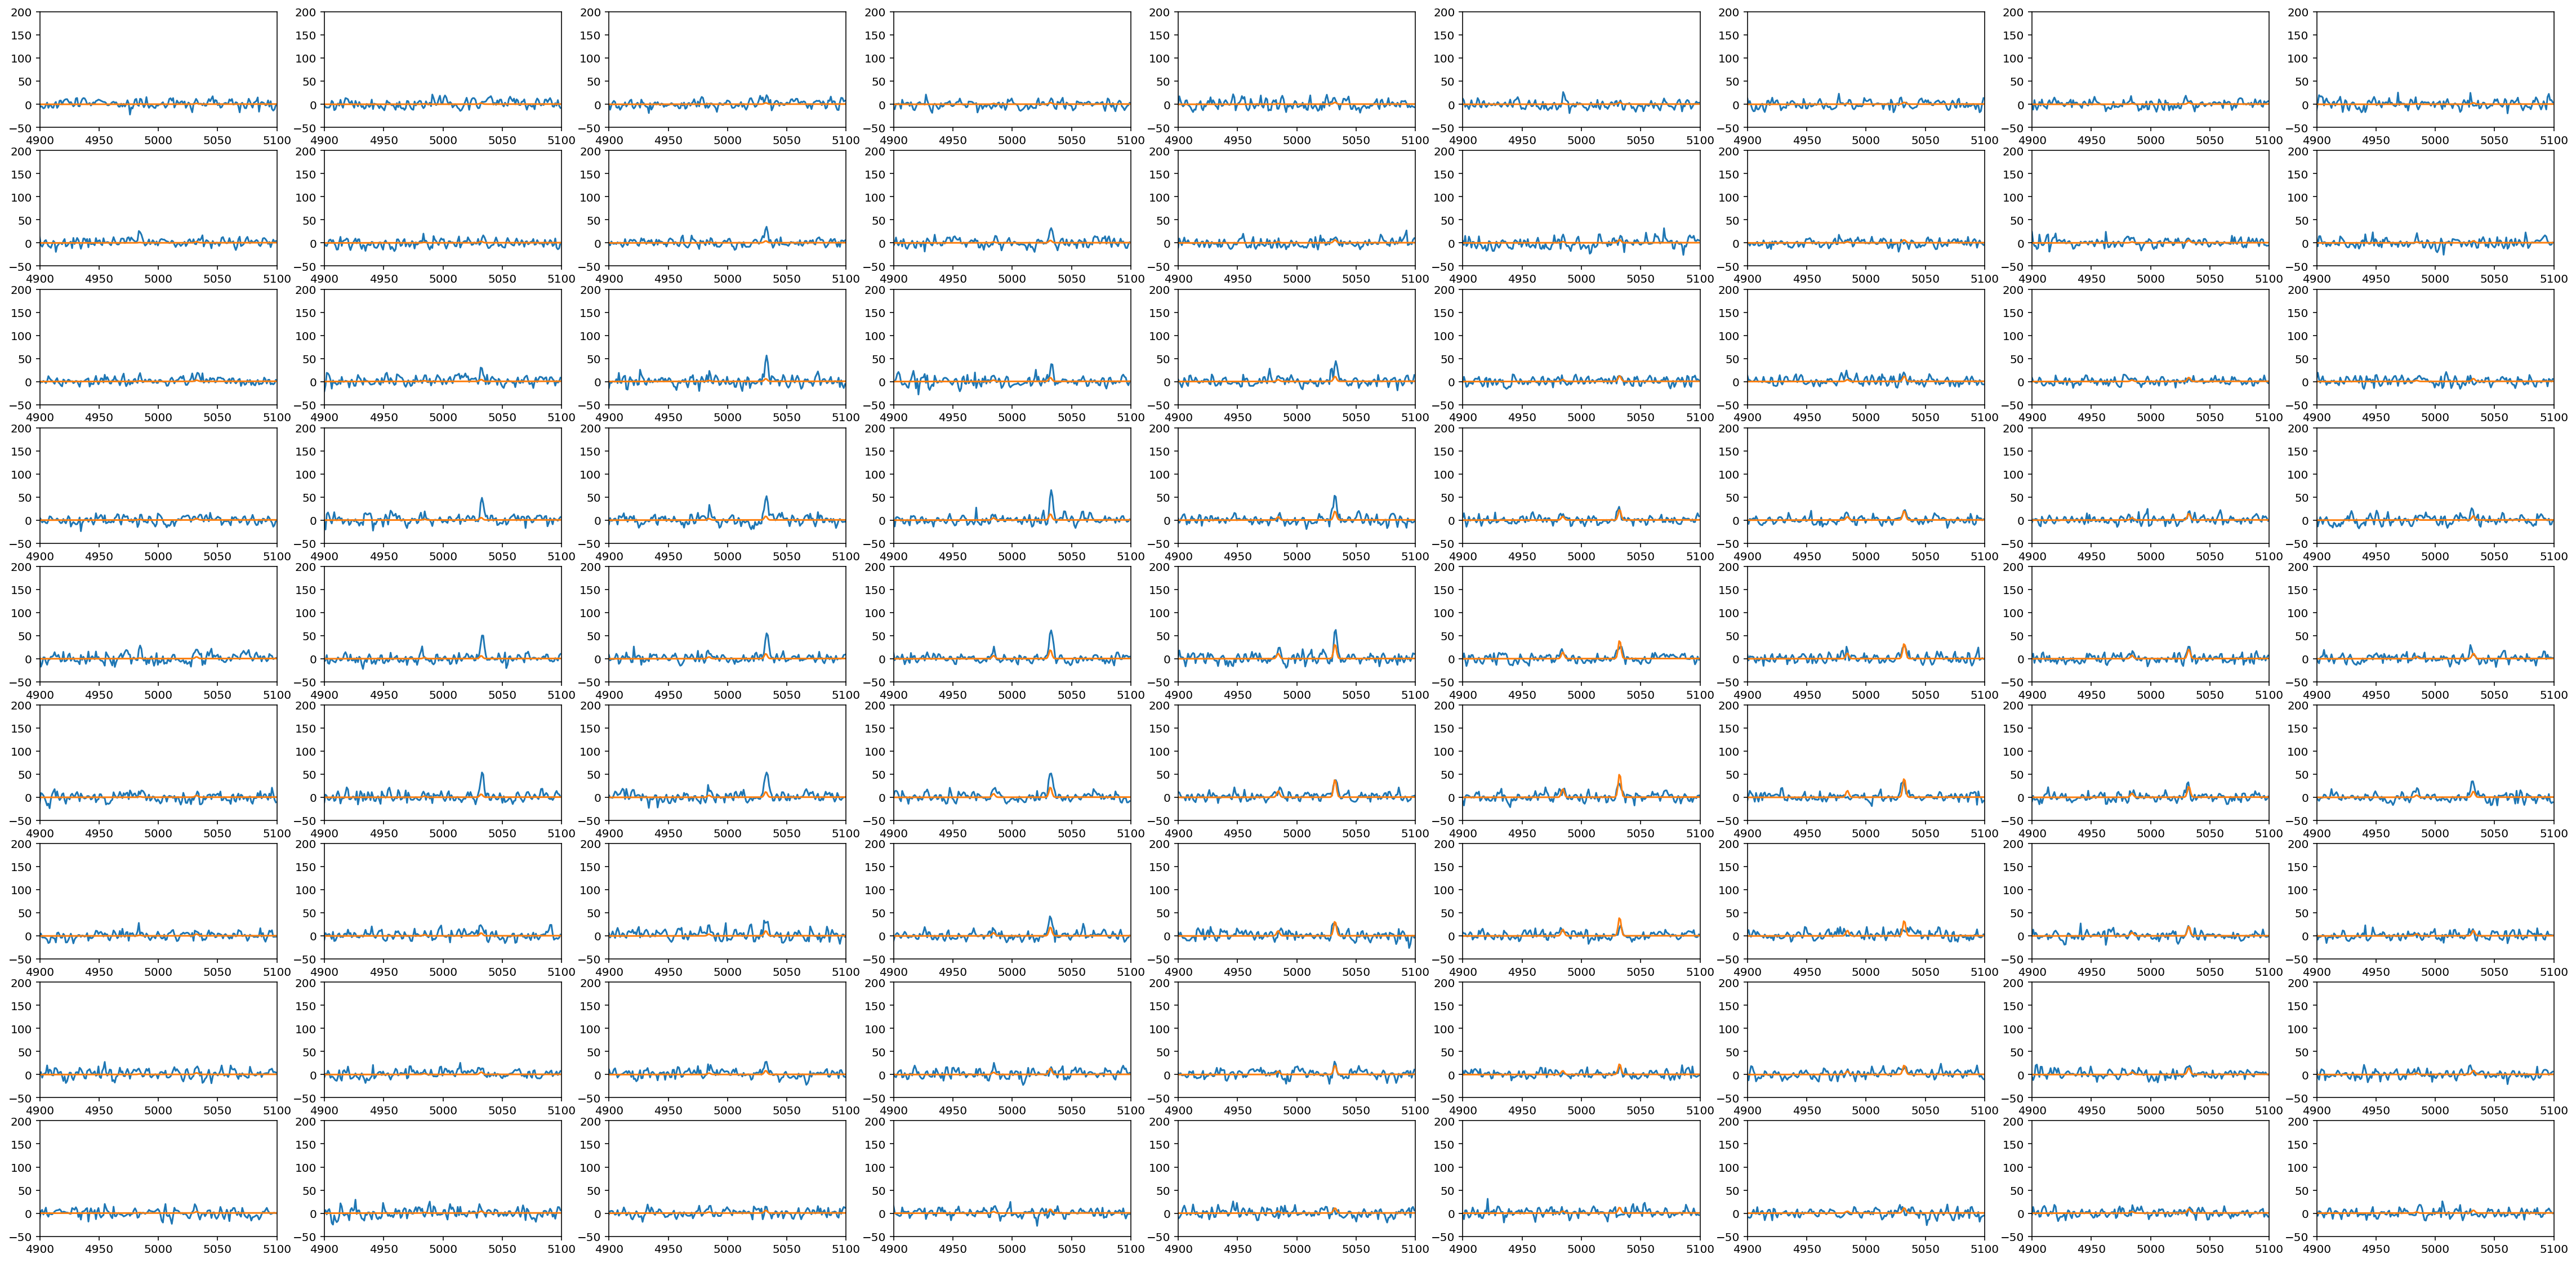

In [28]:
p = 174
PNe_n = PNe_spectra[p]
flux_1D = F_xy_list[p][0]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
            (np.abs(amplitude)/2.85) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]

plt.figure(figsize=(40,20))
for i, spec in enumerate(PNe_n):
    plt.subplot(n_pixels,n_pixels,i+1)
    plt.plot(wavelength, spec)
    plt.plot(wavelength, list_of_gauss[i])
    plt.xlim(4900,5100)
    plt.ylim(-50, 200)
    

## [OIII] / Ha   (+[NII])

Text(0.5, 0, '$M_{5007}$')

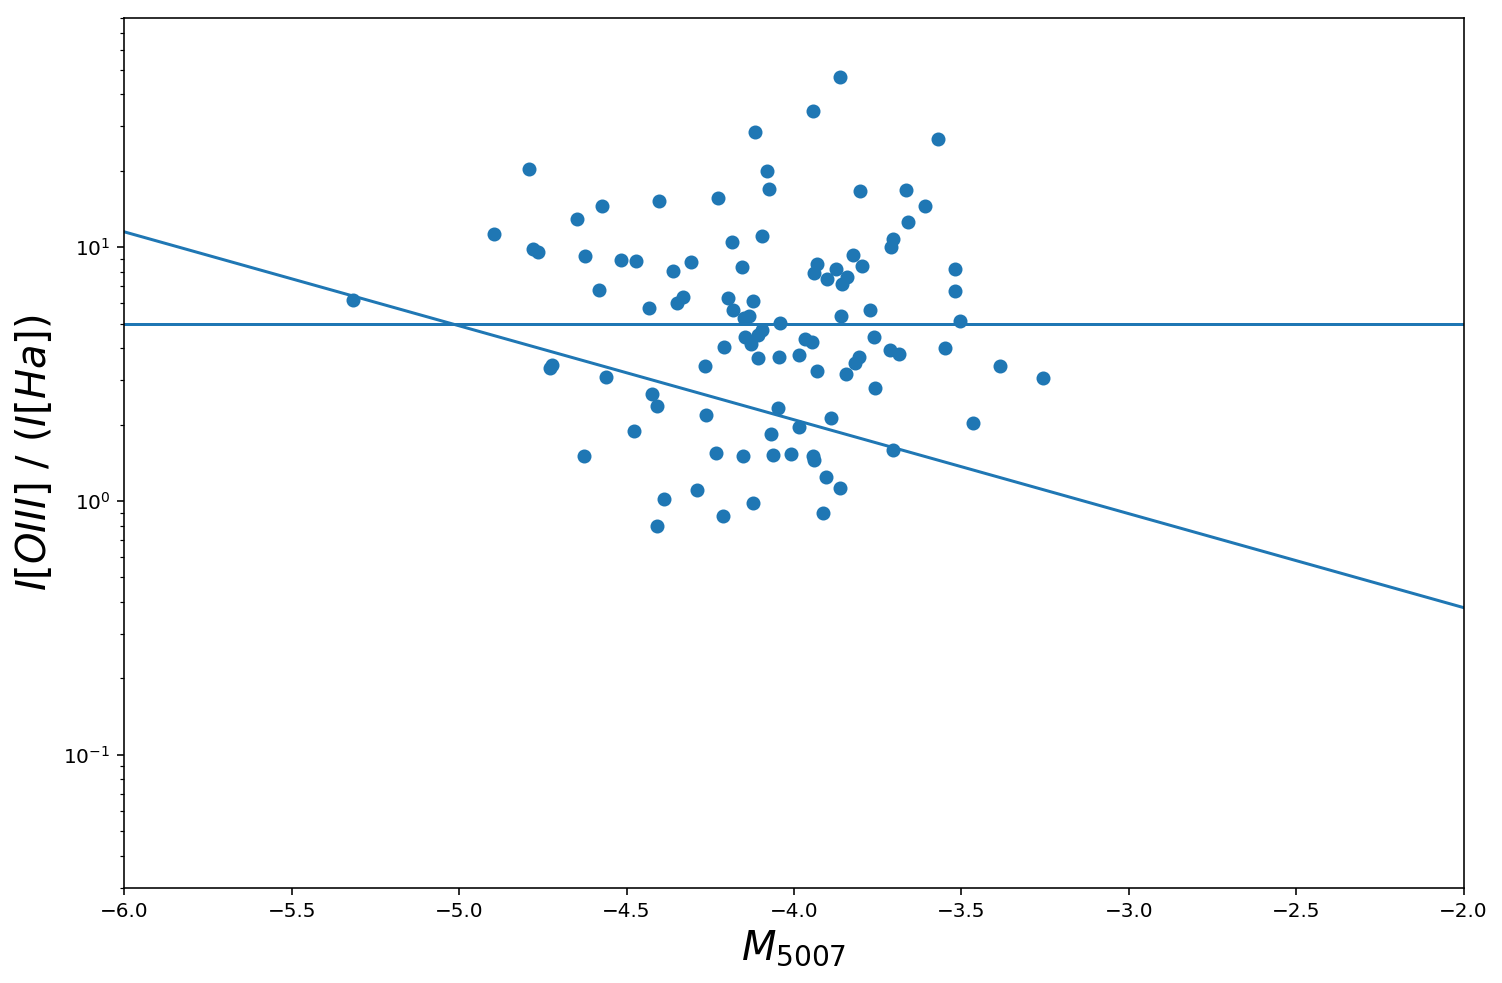

In [20]:
OIII_by_Ha = np.load("exported_data/FCC167/OIII_by_Ha.npy")
PNe_df["OIII/Ha"] = OIII_by_Ha
plt.figure(figsize=(12,8))
plt.yscale("log")
plt.scatter(PNe_df["M 5007"], OIII_by_Ha, )
plt.axhline(5)
plt.ylim(0.03,80)
plt.xlim(-6,-2)
x = np.arange(-6, -2,0.001)
plt.plot(x, 10**((-0.37 * x) - 1.16))
plt.ylabel("$I[OIII] \ / \ (I[Ha])$", fontsize="20")
plt.xlabel("$M_{5007}$", fontsize="20")
# plt.savefig("Plots/FCC167/[OIII]Ha+NII.png")

# Load in data and plot FOV

In [18]:
# Pull out the 1D flux data from 1D fits to do radial comparison

gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

#PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
#PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

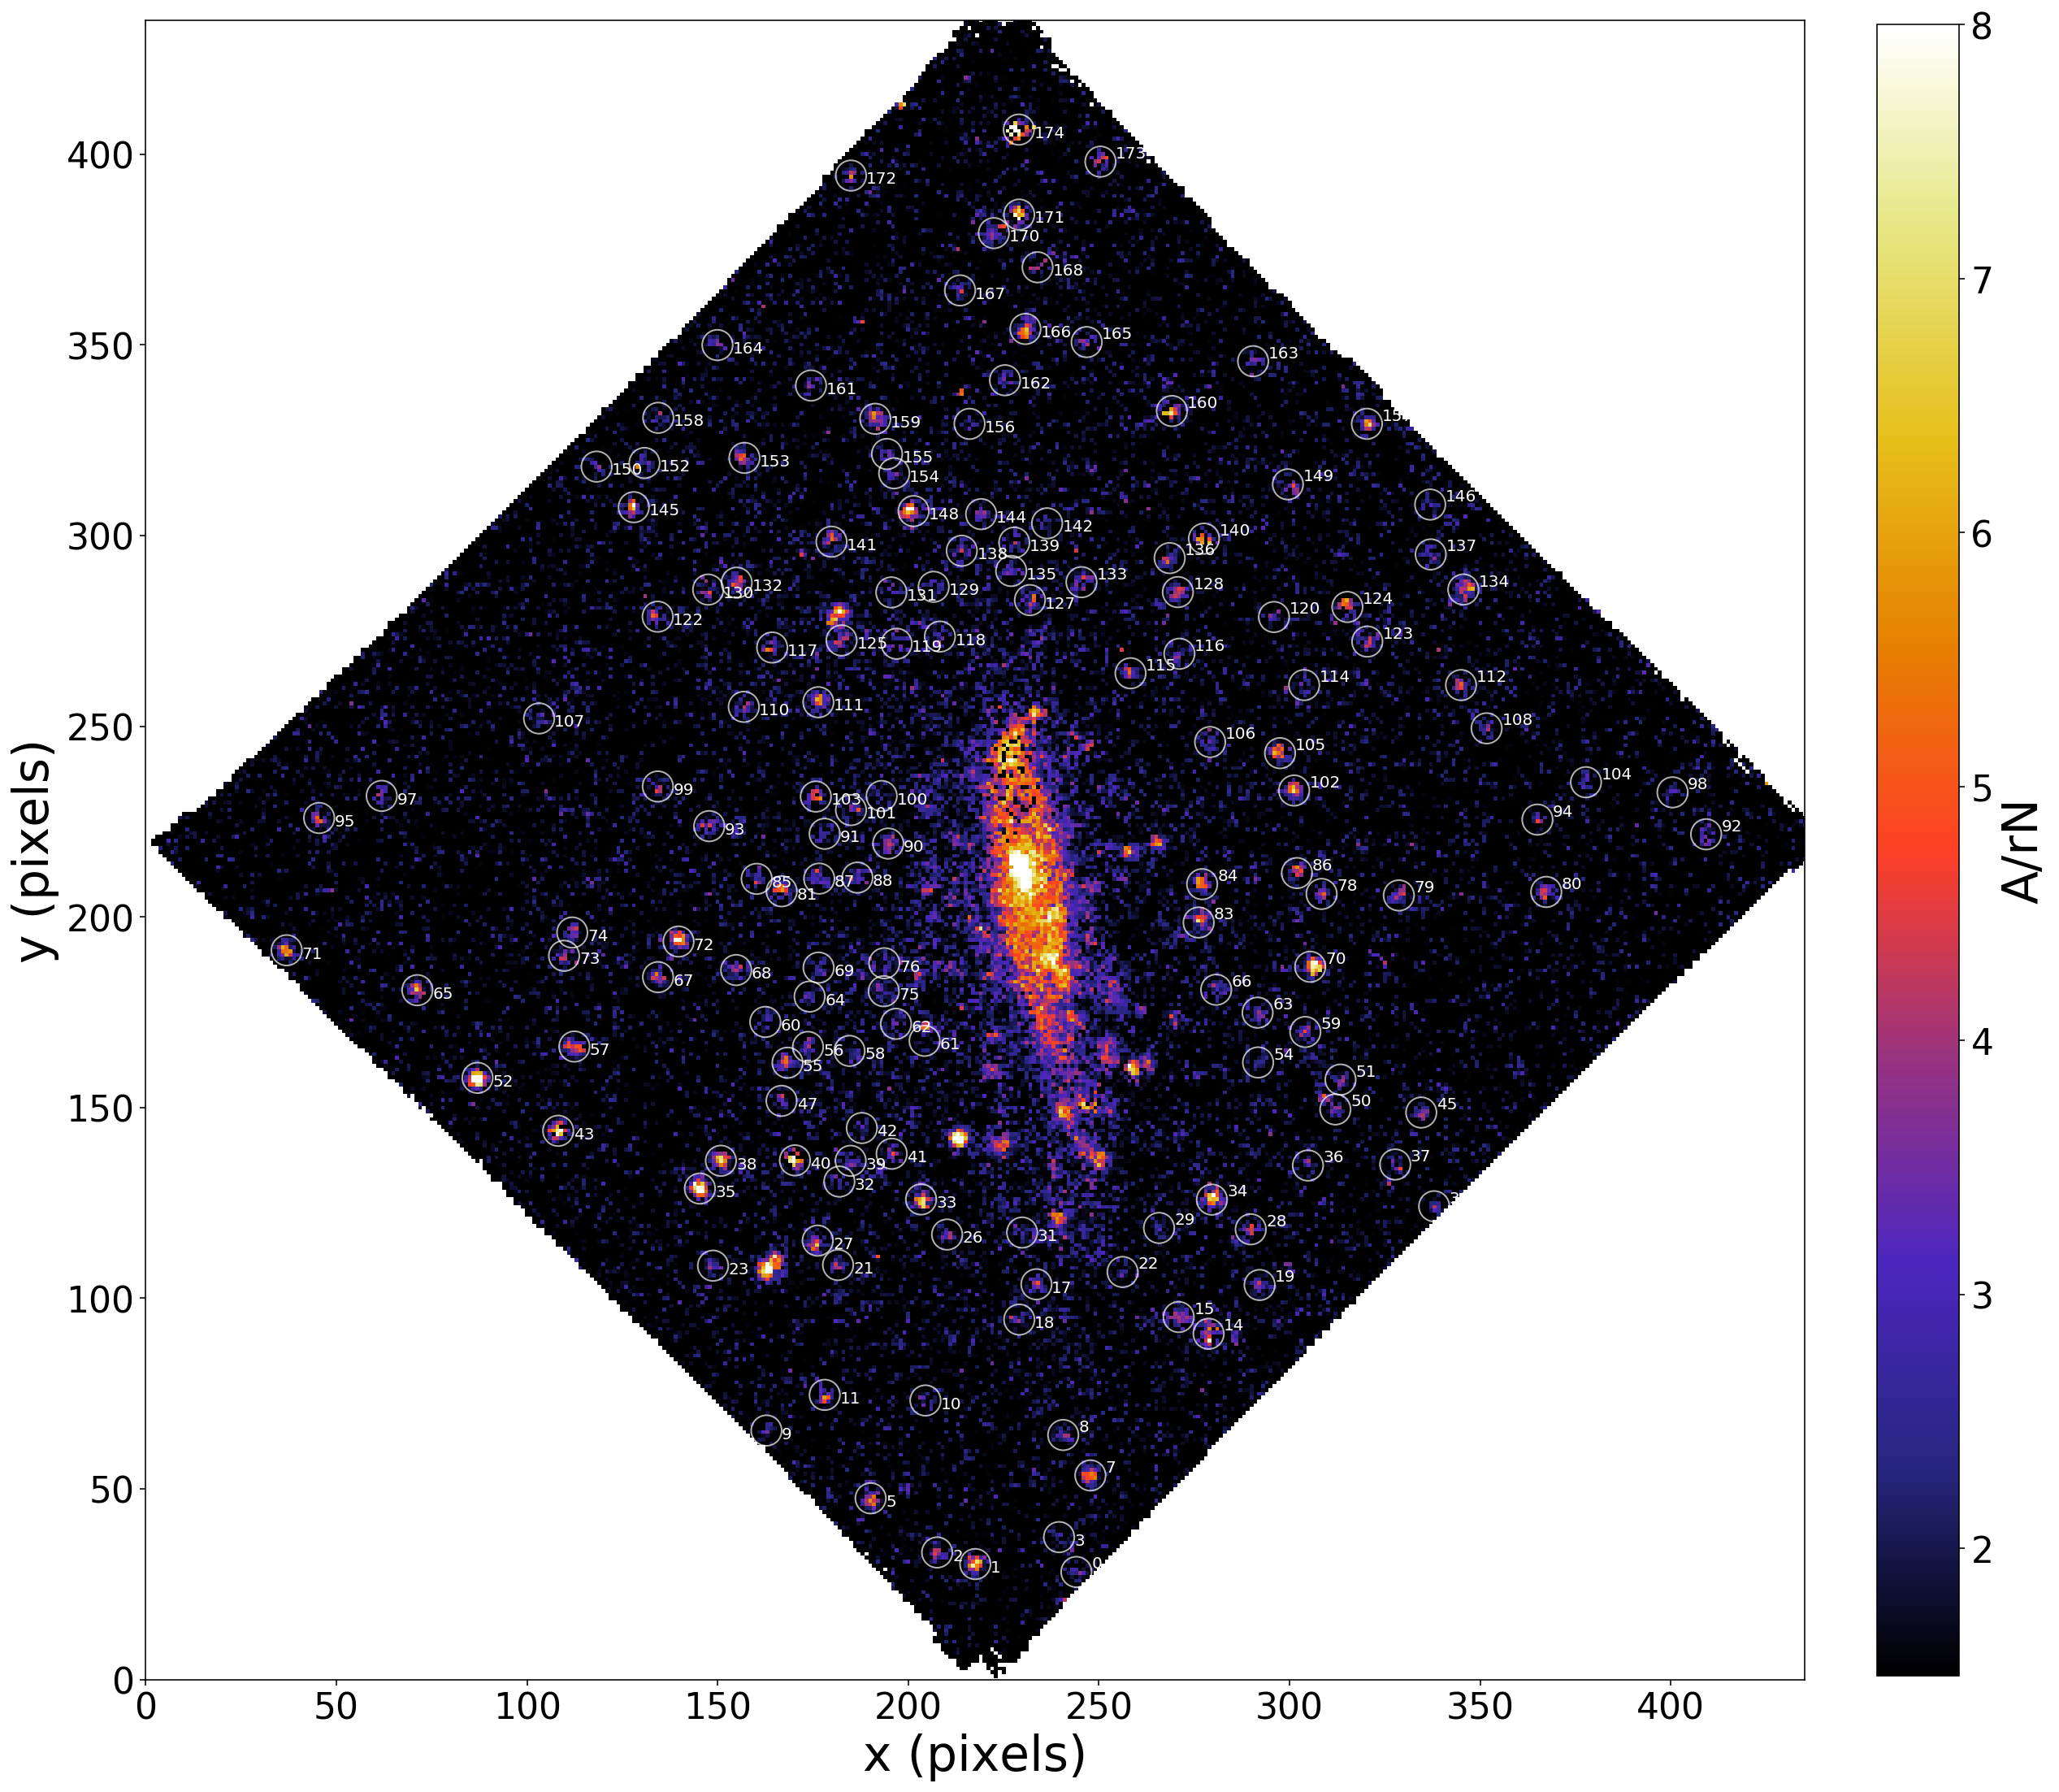

In [28]:

plt.figure(figsize=(20,20))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

plt.ylim(0,435)
plt.xlim(0,435)

#circ_r = plt.Circle((195,100), 45, color="white", fill=False)
#ax.add_artist(circ_r)
# elip_gal = Ellipse((205, 90), 150, 100, angle=1.8*(180/np.pi), fill=False, color="white")
# ax.add_artist(elip_gal)
# 
for i, item in enumerate(x_y_list):
    if PNe_df.iloc[i].Filter == "Y":
        ax = plt.gca()
        circ = plt.Circle((item[0],item[1]),4, color="white",lw=1.0, fill=False, alpha=0.7)
        ax.add_artist(circ)
        if item[0]<240.:
            ax.annotate(i, (item[0]+4, item[1]-2), color="white", size=10)
        else:
            ax.annotate(i, (item[0]+4, item[1]+1), color="white", size=10)

# plt.savefig("Plots/"+gal_name+"/A_rN_circled.pdf")

# Scatter points for measured PNe velocity

In [21]:
# Scatter plot the x y locations of PNe, colour coding them with their velocity

positions = (x_PNe, y_PNe)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8., alpha=0.5)
plt.scatter(x_PNe, y_PNe, c=PNe_df["V (km/s)"], cmap="seismic", s=120)
# plt.scatter(x_PNe, y_PNe, c=PNe_df["m 5007"], cmap="inferno_r", s=120)

cb = plt.colorbar(fraction=0.0455, pad=0.04)
# cb.set_label("$V_{[OIII]} \ (km \ s^{-1}$)", fontsize=20)
#plt.savefig("Plots/"+gal_name+"/PNe_velocity_dist_map.pdf")

NameError: name 'A_rN_plot_shape' is not defined

<Figure size 1152x1152 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,8))
rad = [np.sqrt((x-x_data/2.)**2 + (y - y_data/2.)**2) for x,y in zip(x_PNe, y_PNe)]
plt.scatter(rad, PNe_df["m 5007"])

plt.axhline(26.7)
plt.ylabel("m 5007", fontsize=20)
plt.xlabel("Radius (px)", fontsize=20)
plt.ylim(29,26)
plt.savefig("Plots/"+gal_name+"/rad_v_mag.pdf")

In [ ]:
stellar_vel = 0. # km/s
stellar_dis = 240. # km/s
PNe_vel_ratio = (PNe_df["V (km/s)"].loc[PNe_df["A/rN"]>3.] - stellar_vel)/ stellar_dis

plt.figure(44, figsize=(12,10))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["A/rN"]>3.], PNe_vel_ratio, s=100)
plt.xlabel("$M_{5007}$", fontsize=20)
plt.ylabel("$V_{PNe} - V_{*} / \sigma_*$", fontsize=20)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.ylim(-2,2)
plt.xlim(-5,-2)

# SEP - Source Detection

175


<Figure size 1440x1440 with 0 Axes>

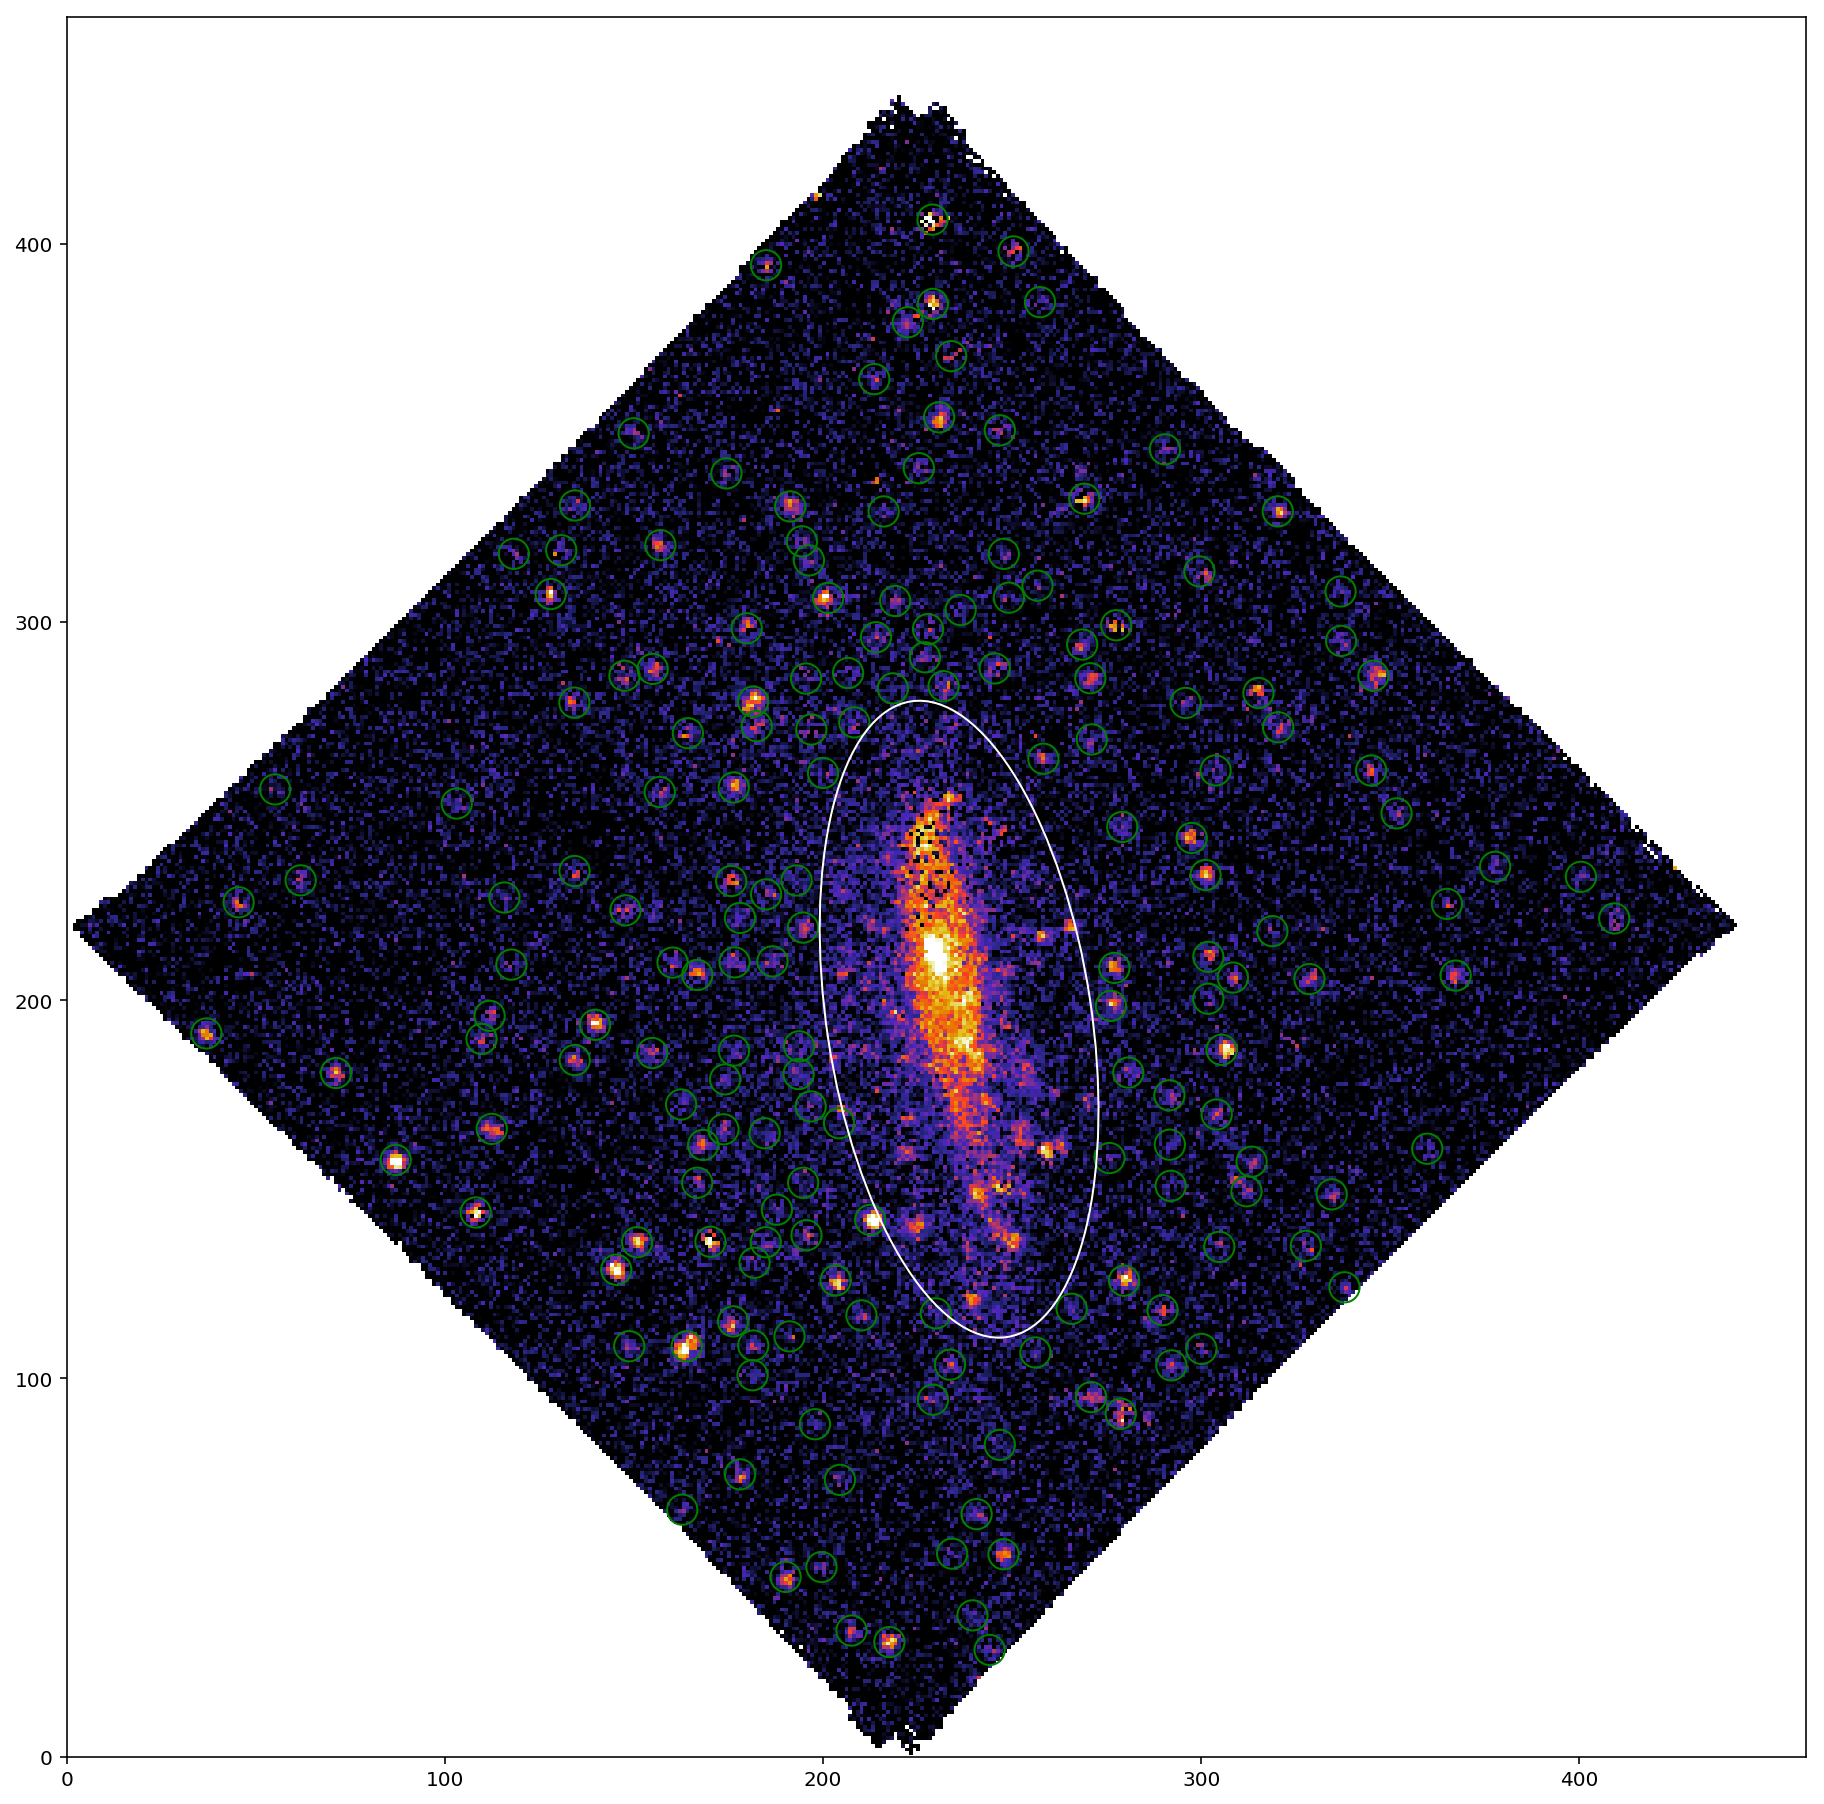

In [81]:
A_rN_plot_shape[A_rN_plot_shape == A_rN_plot_shape[0,0]] = 0.0
plt.figure(figsize=(20,20))

Y, X = np.mgrid[:y_data, :x_data]
if gal_name == "FCC219":
    xe = 190
    ye = 80
    length= 160
    width = 70
    alpha = 0.01
elif gal_name == "FCC167":
    xe = 236
    ye = 195
    length= 170
    width = 70
    alpha = 0.15


elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1
# xc = 195
# yc = 100
# r = 45
# circ_mask_gal = (X - xc)**2 + (Y-yc)**2 <=r**2
#PNe_mask = (X - 379)**2 + (Y-151)**2 <=10**2
        

objects = sep.extract(A_rN_plot_shape, 1.5, clean=True, minarea=8, mask=elip_mask_gal)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=8.)
apertures.plot(color="green")

ax = plt.gca()

#circ_gal = Circle((xc,yc), r, fill=False, color="white")
#ax.add_artist(circ_gal)

elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
#PNe_14 = Circle((379,151), fill=False, color="white")
ax.add_artist(elip_gal)


sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]
plt.xlim(0,460)
plt.ylim(0,460)
print(len(x_sep))

np.save("exported_data/"+gal_name+"/PNe_x_y_list", sep_x_y_list)

# PSF

In [ ]:
PNe_df.nlargest(10, "A/rN")

[174  52  35  40 171  70  72  43  34 148]
FWHM:  3.631092202425937 +/- 0.061091540389568 (1.68%)
Beta:  1.483713589983841 +/- 0.08716659025030646 (5.87%)
LSF:  3.281142208161196 +/- 0.03095540158700828 (0.94%)




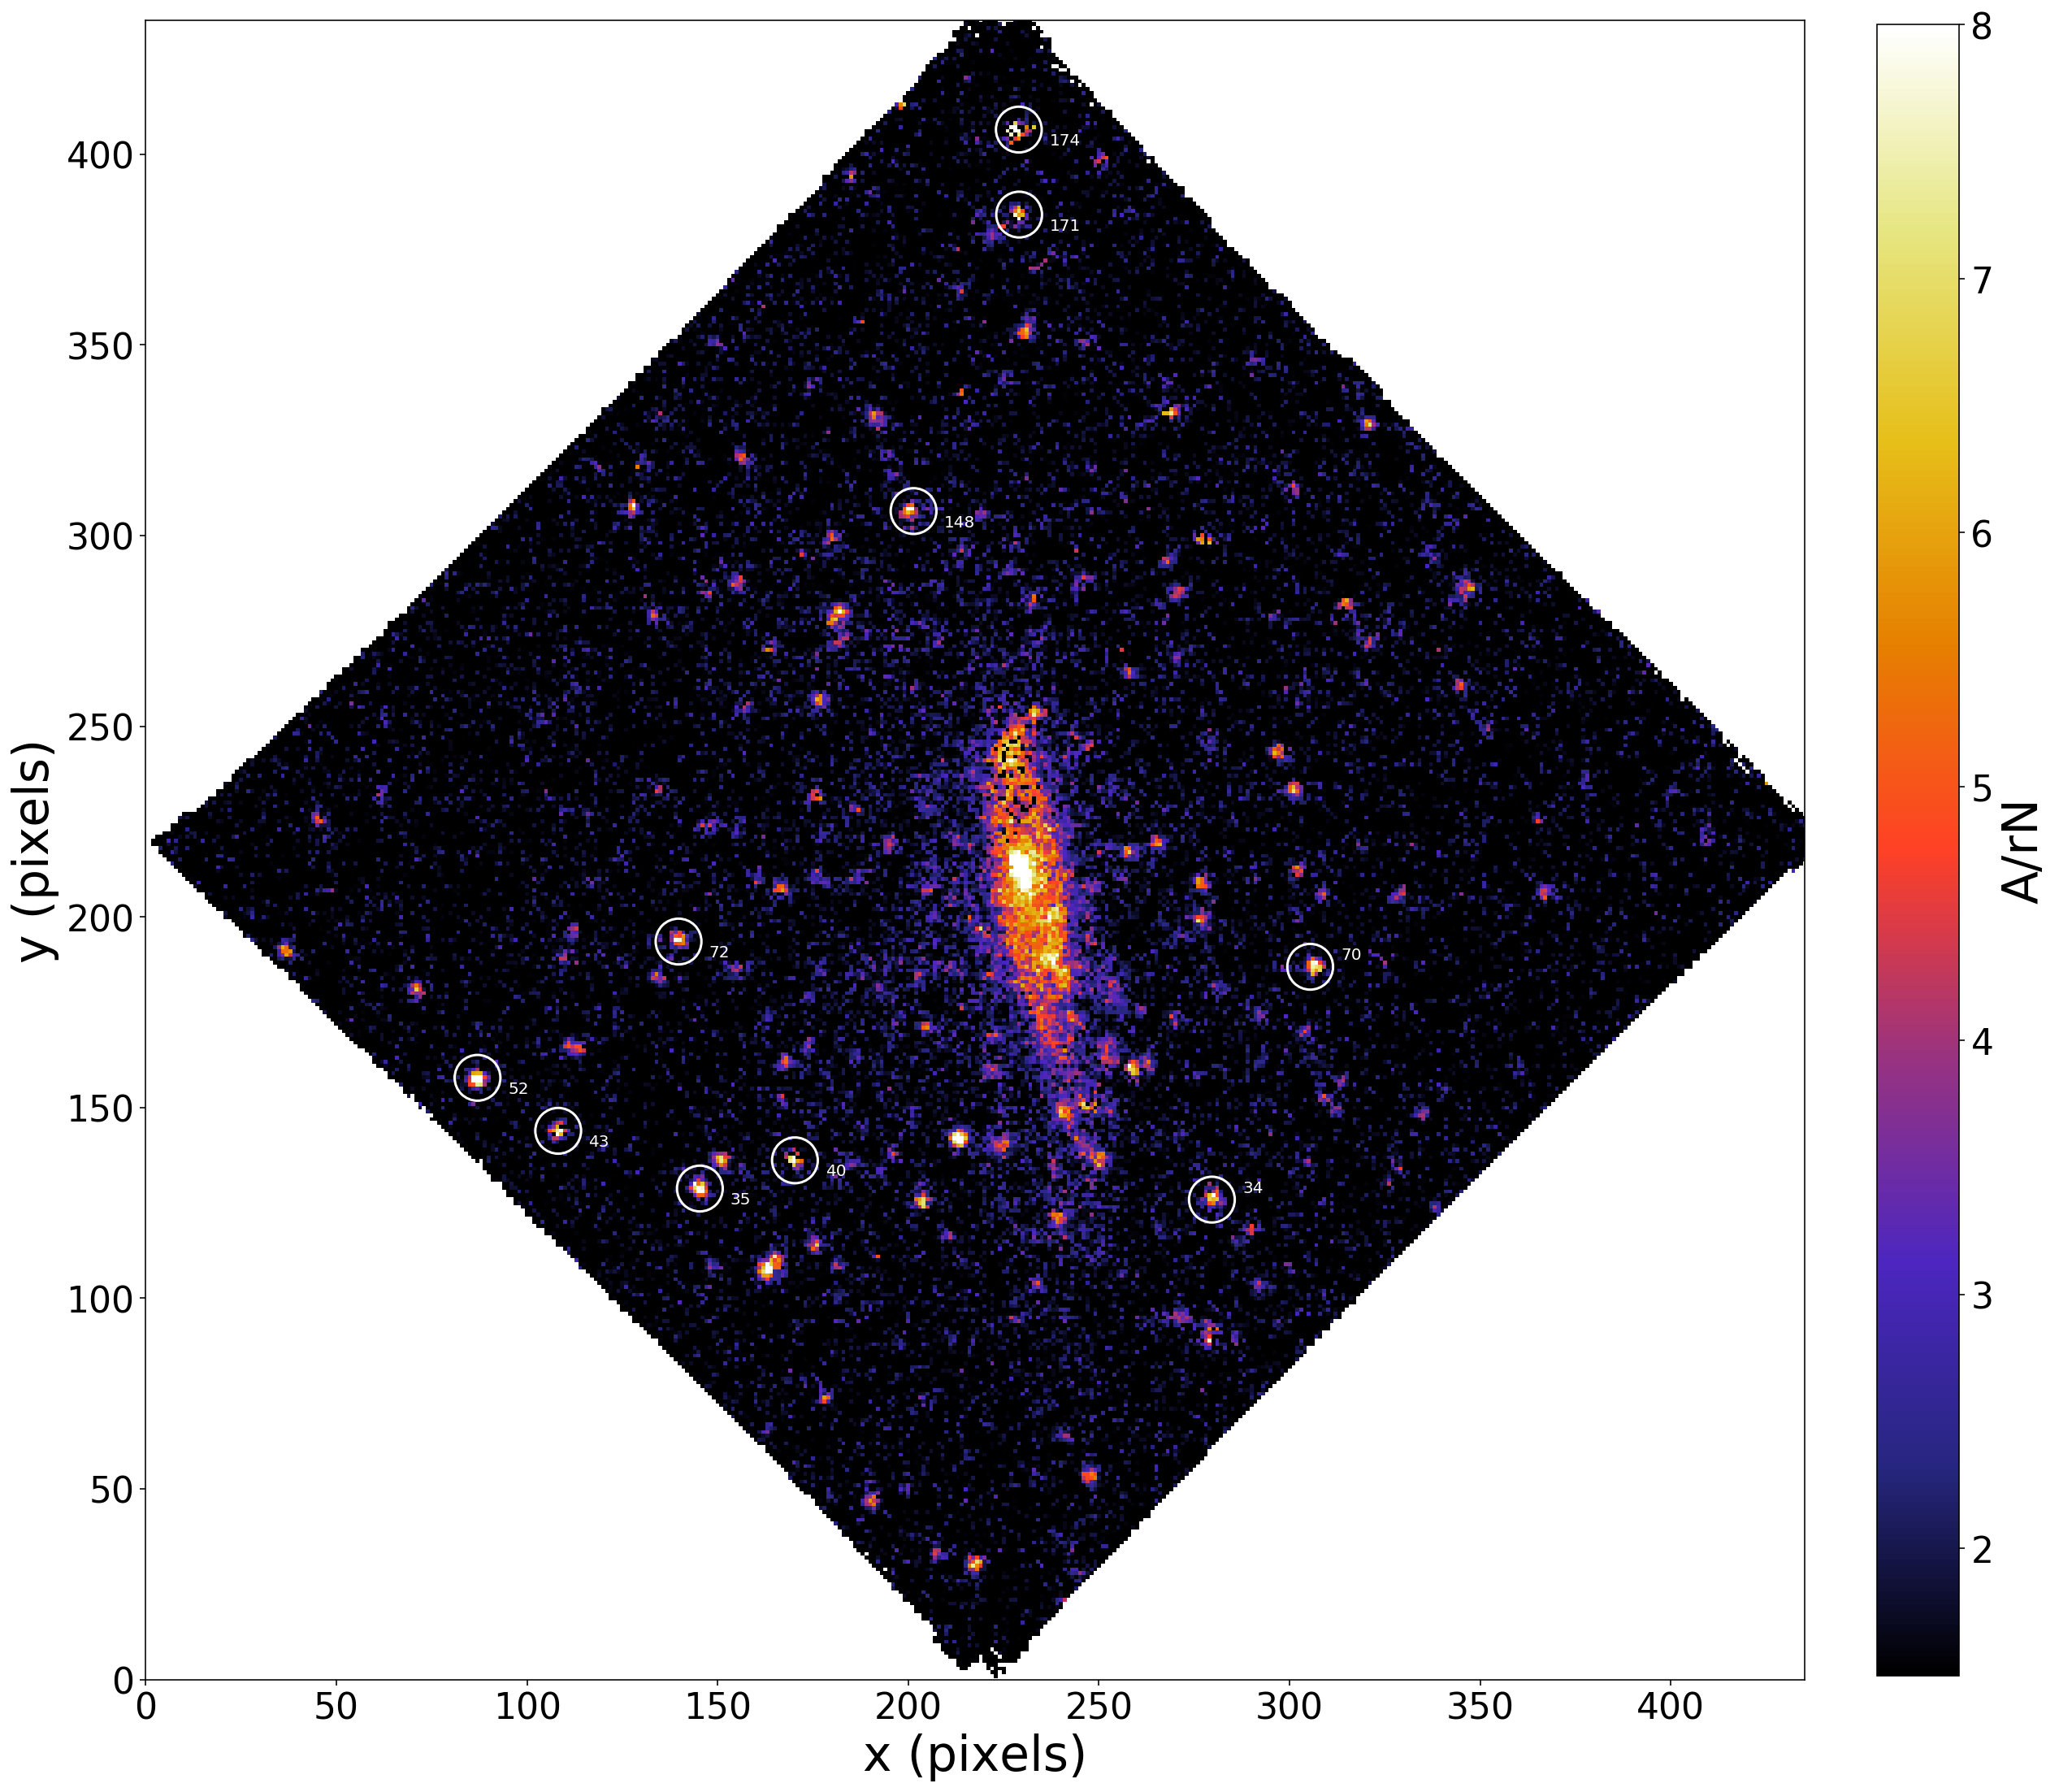

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 574
    # data points      = 229230
    # variables        = 43
    chi-square         = 17778367.6
    reduced chi-square = 77.5714487
    Akaike info crit   = 997468.441
    Bayesian info crit = 997913.168
[[Variables]]
    moffat_amp_000:  300.260559 +/- 6.92465317 (2.31%) (init = 200)
    x_000:           3.98825870 +/- 0.05362955 (1.34%) (init = 4.5)
    y_000:           2.82587807 +/- 0.05412094 (1.92%) (init = 4.5)
    wave_000:        5032.70383 +/- 0.03767765 (0.00%) (init = 5038.349)
    gauss_bkg_000:   0 (fixed)
    gauss_grad_000:  0 (fixed)
    moffat_amp_001:  273.285744 +/- 6.14602379 (2.25%) (init = 200)
    x_001:           3.54438488 +/- 0.05518217 (1.56%) (init = 4.5)
    y_001:           4.09411856 +/- 0.05528617 (1.35%) (init = 4.5)
    wave_001:        5037.93581 +/- 0.03740814 (0.00%) (init = 5038.349)
    gauss_bkg_001:   0 (fixed)
    gauss_grad_001:  0 (fixed)
    moffat_amp_002:  26

In [35]:
### Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(4, "m 5007").index.values
sel_PNe = PNe_df.loc[PNe_df["Filter"]=="Y"].loc[PNe_df["PNe number"] != 71].nlargest(10, "A/rN").index.values
#sel_PNe = PNe_df.loc[PNe_df["PNe number"] != 1].nlargest(10, "A/rN").index.values

#sel_PNe = [26, 32,45,20,109]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe]
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.01)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.1, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=mean, min=mean-50., max=mean+50.)
    PSF_params.add("gauss_bkg_{:03d}".format(n),  value=0.000, vary=False)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.000, vary=False)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5007*(1+z))    
    
PSF_params.add('FWHM', value=4.0,  min=0.01, vary=True)
PSF_params.add("beta", value=2.5,  min=0.01, vary=True) 
PSF_params.add("LSF",  value=2.81, min=0.01, vary=True)

PSF_results = minimize(PSF_residuals_3D, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, z), nan_policy="propagate")

print("FWHM: ", PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr / PSF_results.params["FWHM"].value)*100) )
print("Beta: ", PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr / PSF_results.params["beta"].value)*100) )
print("LSF: " , PSF_results.params["LSF"].value , "+/-", PSF_results.params["LSF"].stderr,  "({:3.2f}%)".format((PSF_results.params["LSF"].stderr  / PSF_results.params["LSF"].value)*100)  )
print("\n")
3.27238912e+08
# Plot locations of PNe used for PSF
plt.figure(figsize=(20,20))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap",  vmin=1.5, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=30)
cb.ax.tick_params(labelsize=22)

plt.xlabel("x (pixels)", fontsize=30)
plt.ylabel("y (pixels)", fontsize=30)

plt.tick_params(labelsize = 22)

plt.ylim(0,435)
plt.xlim(0,435)

#circ_r = plt.Circle((195,100), 45, color="white", fill=False)
#ax.add_artist(circ_r)
# elip_gal = Ellipse((205, 90), 150, 100, angle=1.8*(180/np.pi), fill=False, color="white")
# ax.add_artist(elip_gal)
# 
for (i, item), n in zip(enumerate(x_y_list[sel_PNe]), sel_PNe):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="white",lw=1.5, fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(n, (item[0]+8, item[1]-4), color="white", size=10)
    else:
        ax.annotate(n, (item[0]+8, item[1]+2), color="white", size=10)
plt.show()
print(report_fit(PSF_results, show_correl=False))






In [ ]:
##FCC219
FWHM:  4.105751820187509 +/- 0.05649629668406493 (1.38%)
Beta:  3.0772790045586365 +/- 0.28231323253732055 (9.17%)
LSF:  3.0193090265886258 +/- 0.02975419170253552 (0.99%)
    
### FCC219
FWHM:  4.225551120124684 +/- 0.0504332458452995 (1.19%)
Beta:  3.9287344284404284 +/- 0.5053798997995427 (12.86%)
LSF:  3.058924941353654 +/- 0.025119013010803878 (0.82%)
    
##FCC167 - 10
[174  52  35  40 171  70  72  43  34 148]
FWHM:  3.631092202425937 +/- 0.061091540389568 (1.68%)
Beta:  1.483713589983841 +/- 0.08716659025030646 (5.87%)
LSF:  3.281142208161196 +/- 0.03095540158700828 (0.94%)
    
### FCC167
FWHM:  3.6170243630433134 +/- 0.06035186321054143 (1.67%)
Beta:  1.713763566483607 +/- 0.11441290579054787 (6.68%)
LSF:  3.175544302062553 +/- 0.031039290951306957 (0.98%)
    
## FCC167
[26, 32, 45, 20, 109]
FWHM:  3.8372173253777007 +/- 0.0733347233672999 (1.91%)
Beta:  1.8336749022627725 +/- 0.1607585314548645 (8.77%)
LSF:  3.2281770568793418 +/- 0.0356446171710133 (1.10%)
    
[174  52  35  40 171  70  72  43  34 148]
FWHM:  3.6555085068319846 +/- 0.06650923980307522 (1.82%)
Beta:  1.5171678061020073 +/- 0.09211258349231453 (6.07%)
LSF:  3.3104736664726735 +/- 0.033735709852824876 (1.02%)

In [115]:
PNe_df["m 5007"].iloc[[39, 42, 68, 71]]

39    30.014036
42    28.062477
68    27.398909
71    27.358250
Name: m 5007, dtype: float64

## Comparison with literature

In [33]:
gal_hdulist = fits.open(gal_name+"_data/"+gal_name+"center.fits")

x_y_list = np.load("exported_data/"+gal_name+"/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

hdr_wcs = gal_hdulist[1].header
wcs_obj = WCS(hdr_wcs, naxis=2)

for i in np.arange(0, len(x_PNe)):
    Ra_Dec = utils.pixel_to_skycoord(x_PNe[i],y_PNe[i], wcs_obj).to_string("hmsdms").split()
    PNe_df.loc[i,"Ra (J2000)"] = Ra_Dec[0]
    PNe_df.loc[i,"Dec (J2000)"] = Ra_Dec[1]

## FCC167

In [51]:
c = ascii.read("NGC1380_PNe_from_paper.txt", data_start=1)
lit_RA = list(c["RA"])
lit_Dec = list(c["Dec"])
lit_m = np.array(c["mag"])

x_y_lit = np.ones((len(x_PNe),2))
for i in np.arange(0, len(lit_RA)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(lit_RA[i], u.hourangle), dec=Angle(lit_Dec[i], u.deg), frame="fk5"), wcs_obj)

smallest_sep = []
for r,d in zip(lit_RA, lit_Dec):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(Angle(r, u.hourangle), Angle(d, u.deg), frame="fk5")
        c2 = SkyCoord(Angle(r1, u.hourangle), Angle(d1, u.deg), frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)
    
diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]
print(potential_diff)
print(np.where(diff<0.001))

indx =np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))
#print(indx[[0,2,6,20]])
#print(lit_m[[0,2,6,20]])
PNe_df.loc[indx[np.where(diff<0.001)]]

[0.0001147  0.00099191 0.00032357 0.00041565 0.00027396]
(array([ 0,  1,  2,  6, 20]),)


,PNe number,Ra (J2000),Dec (J2000),V (km/s),m 5007,M 5007,[OIII] Flux,M 5007 error,A/rN,rad D,redchi,Filter,[OIII]/Hb,Flux error,F[OIII] err percent,OIII/Ha
105,105,03h36m27.6516s,-34d58m00.2475s,-162.572831,27.870699,-3.760980,2.268404e-17,NaN,4.177366,NaN,1.031042,Y,6.335699,1.300286e-18,5.732164,4.407040
107,107,03h36m28.2602s,-34d57m57.1921s,-145.570366,27.659577,-3.972102,2.755302e-17,NaN,3.353217,NaN,1.022538,Y,4.995429,1.805498e-18,6.552813,0.000000
93,93,03h36m28.0016s,-34d58m14.8502s,-110.938476,26.852739,-4.778940,5.793010e-17,NaN,7.411431,NaN,1.022187,Y,3.922341,2.214920e-18,3.823436,9.842604
66,66,03h36m26.3736s,-34d58m29.4728s,12.141866,27.159870,-4.471809,4.365681e-17,NaN,6.180837,NaN,1.026172,Y,8.170374,1.930254e-18,4.421427,8.790239
85,85,03h36m25.6455s,-34d58m18.9537s,-99.128209,27.535839,-4.095841,3.087909e-17,NaN,5.811747,NaN,1.032757,Y,5.690026,1.385662e-18,4.487380,11.094197


In [68]:
print(PNe_df["[OIII] Flux"].loc[indx[[ 0,  1,  2,  6, 20]]].values)
print([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866])
print(lit_m[[ 0,  1,  2,  6, 20]])
print(np.abs([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866] - lit_m[[ 0,  1,  2,  6, 20]]))

[2.26840373e-17 2.75530161e-17 5.79301040e-17 4.36568107e-17
 3.08790930e-17]
[27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866]
[26.585 26.718 26.725 26.809 27.203]
[0.53696    0.94157713 0.12773923 0.35086999 0.33283866]


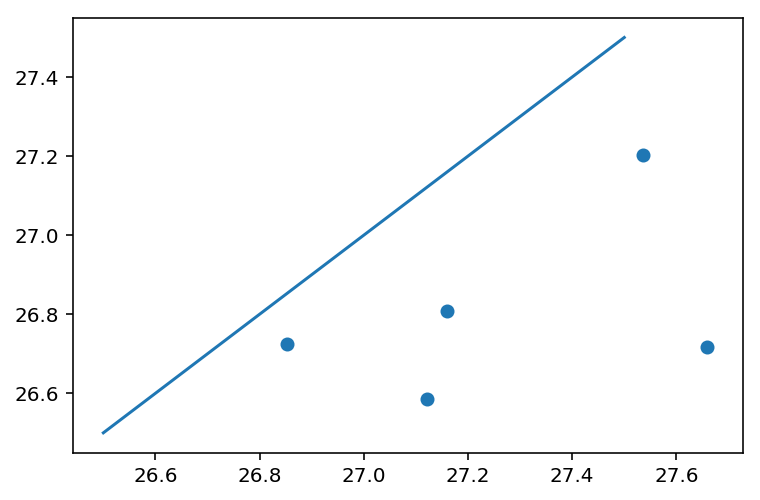

In [61]:
plt.scatter([27.12196, 27.65957713, 26.85273923, 27.15986999, 27.53583866], lit_m[[ 0,  1,  2,  6, 20]] )
plt.plot(np.arange(26.5,28), np.arange(26.5,28))

In [69]:
[i*10**((3.56*(0.037))/2.5) for i in [2.26840373e-17, 2.75530161e-17, 5.79301040e-17, 4.36568107e-17, 3.08790930e-17]]

[2.5609927719704978e-17,
 3.110692957557725e-17,
 6.540219259095436e-17,
 4.9287864929575076e-17,
 3.486201901898865e-17]

In [70]:
[-2.5 * np.log10(i) - 13.74 for i in [2.5609927719704978e-17, 3.110692957557725e-17, 6.540219259095436e-17, 4.9287864929575076e-17, 3.486201901898865e-17]]

[27.738979118157076,
 27.52785713505306,
 26.721019229564305,
 27.028149985927207,
 27.40411866129412]

In [71]:
[27.738979118157076,
 27.52785713505306,
 26.721019229564305,
 27.028149985927207,
 27.40411866129412] - lit_m[[ 0,  1,  2,  6, 20]]

array([ 1.15397912,  0.80985714, -0.00398077,  0.21914999,  0.20111866])

In [57]:
PNe_df.loc[PNe_df["PNe number"]==106]

,PNe number,Ra (J2000),Dec (J2000),V (km/s),m 5007,M 5007,[OIII] Flux,M 5007 error,A/rN,rad D,redchi,Filter,[OIII]/Hb,Flux error,F[OIII] err percent,OIII/Ha
106,106,03h36m27.5423s,-34d57m59.2032s,-258.439382,27.12196,-4.509719,4.520806e-17,NaN,8.573393,NaN,1.002386,Y,8.561205,1.677209e-18,3.709978,inf


Text(0, 0.5, 'Dec')

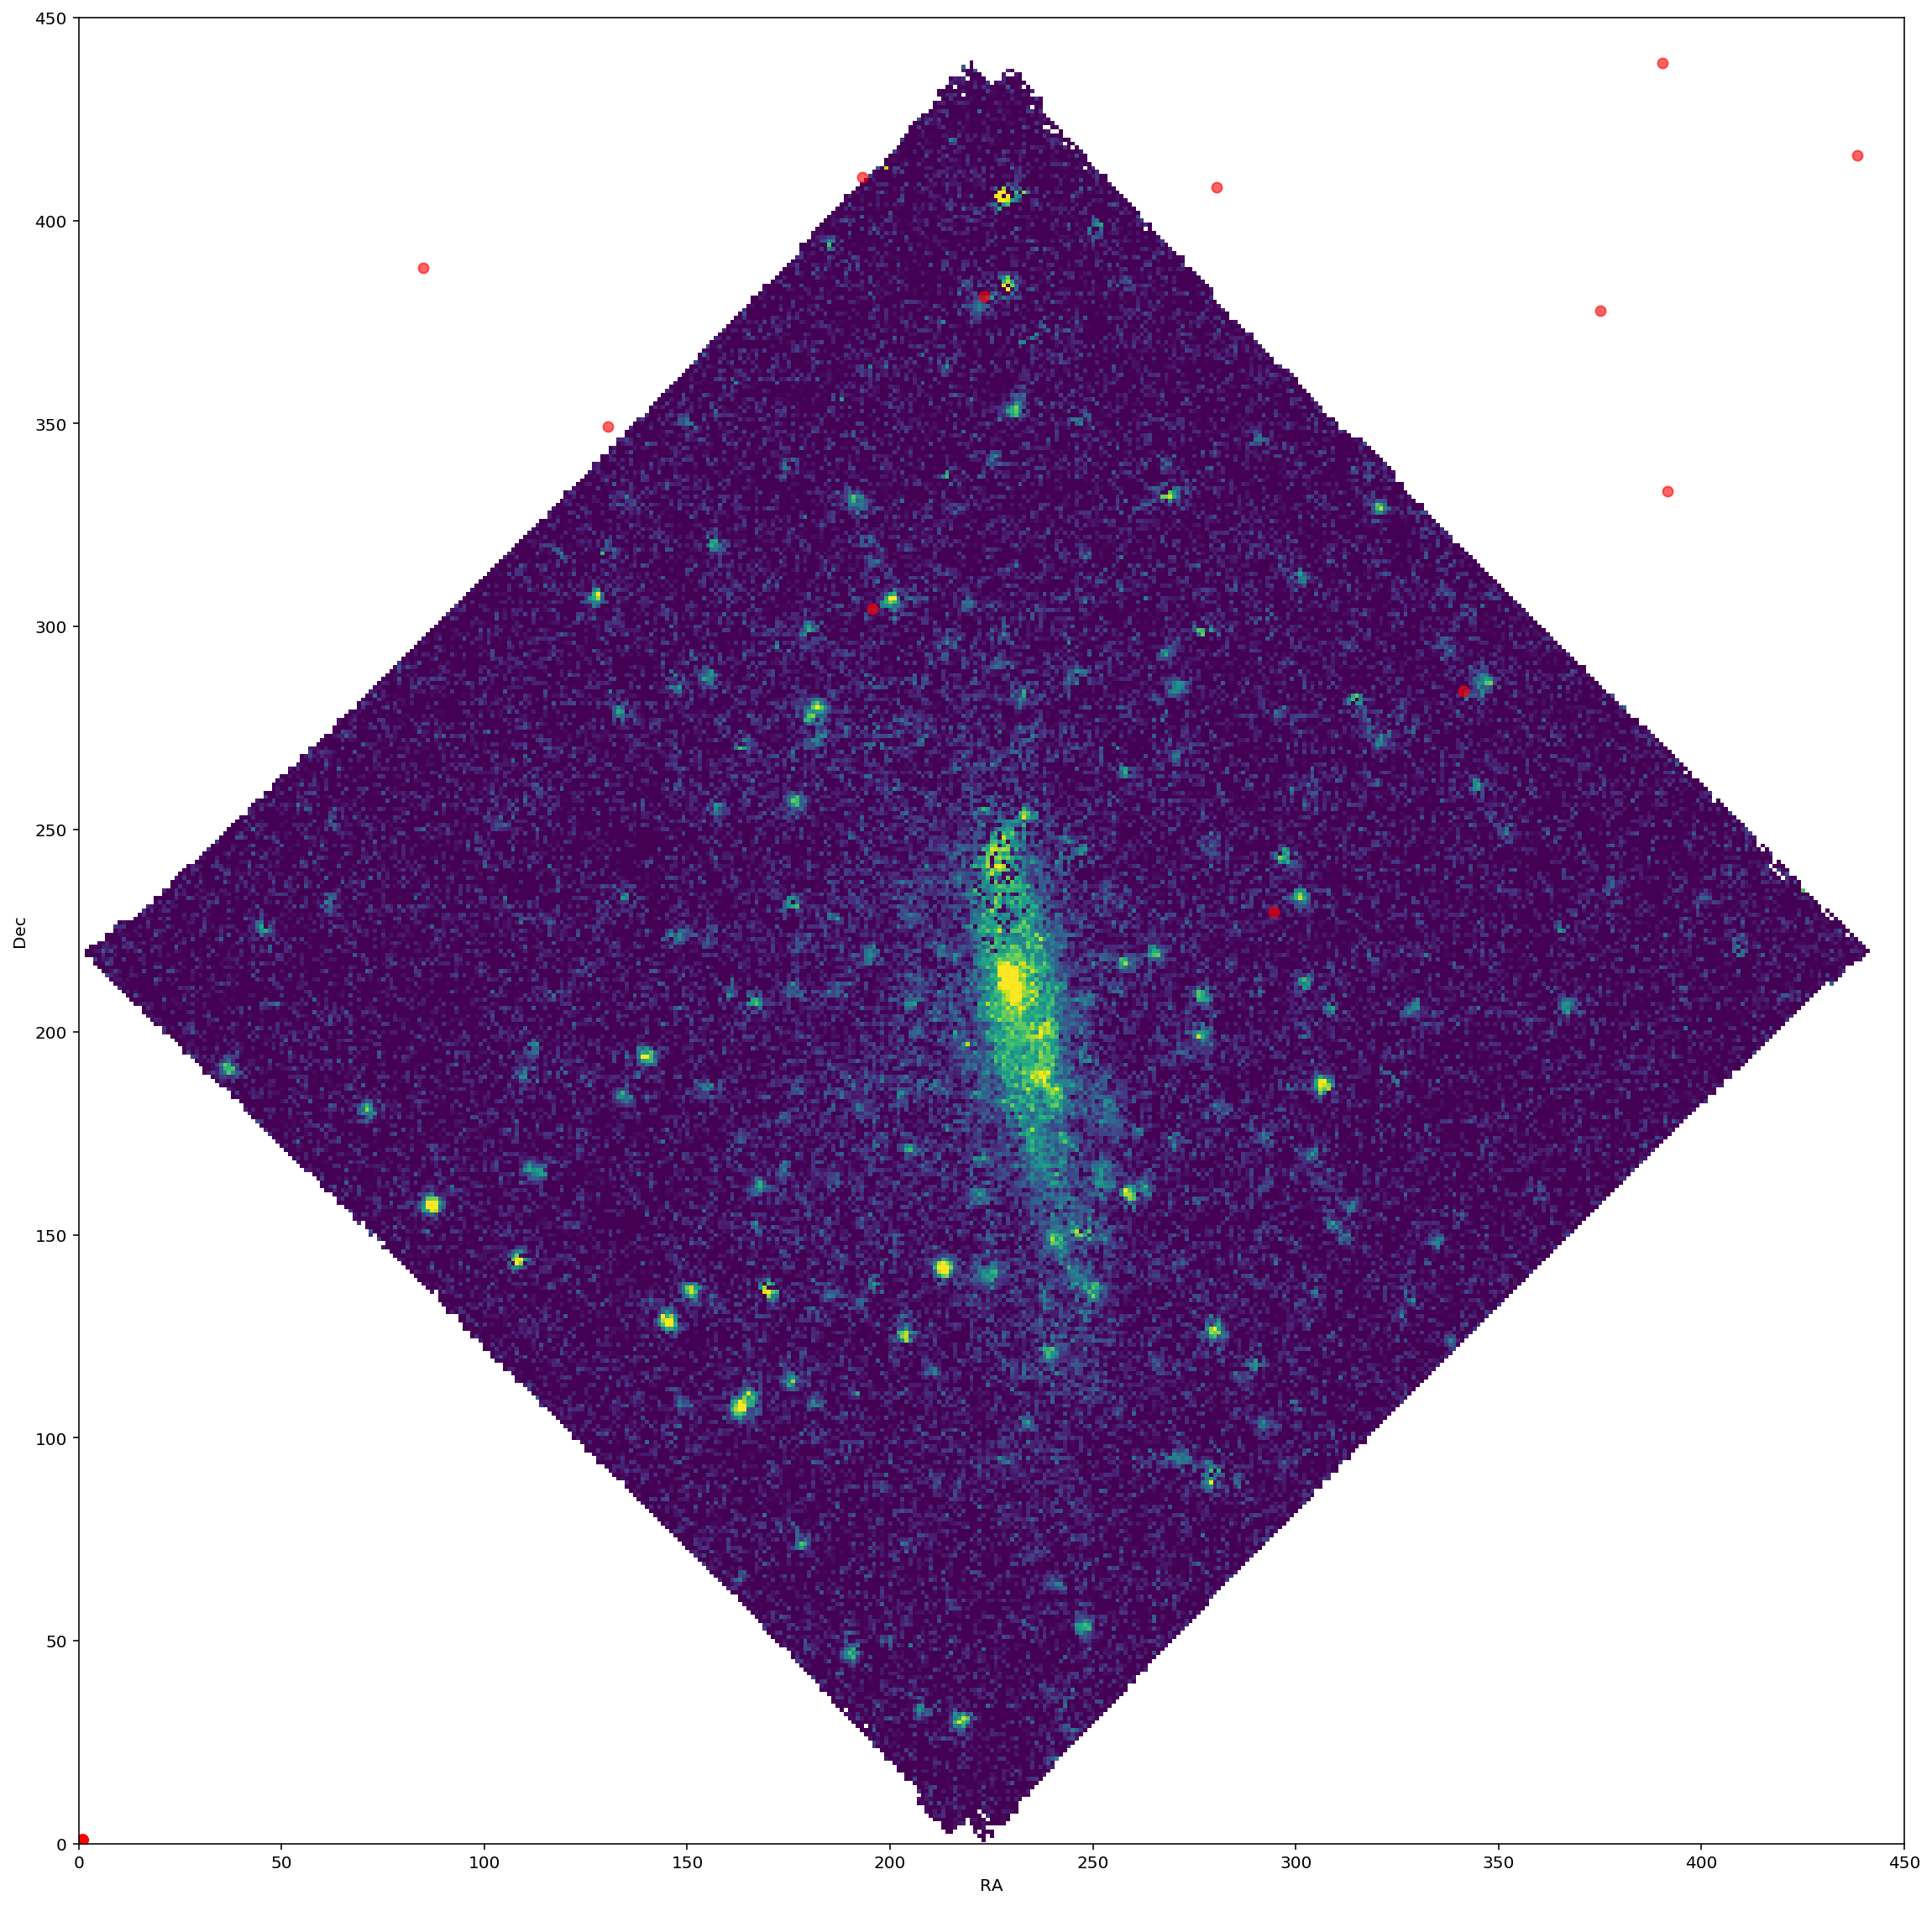

In [40]:
gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)


fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="r", alpha=0.6)
plt.xlim(0,450)
plt.ylim(0,450)
plt.xlabel('RA')
plt.ylabel('Dec')

## FCC219

In [ ]:
PNe_hdulist = fits.open("PNe1404.fit")
list_1404 = PNe_hdulist[1].data
list_1404 = list_1404[-47:]
RA_1404 =    [list_1404[i][7] for i in np.arange(0,len(list_1404))]
Dec_1404 =   [list_1404[i][8] for i in np.arange(0,len(list_1404))]
m5007_1404 = [list_1404[i][4] for i in np.arange(0,len(list_1404))]

x_y_lit = np.ones((len(x_PNe),2))
for i in np.arange(0, len(list_1404)):
    x_y_lit[i] = utils.skycoord_to_pixel(SkyCoord(ra=Angle(RA_1404[i], u.hourangle), dec=Angle(Dec_1404[i], u.deg), frame="fk5"), wcs_obj)


gauss_1D_A = np.load("exported_data/"+gal_name+"/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/"+gal_name+"/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/"+gal_name+"/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)


fig = plt.figure(figsize=(20,20))
# fig.add_subplot(111, projection=wcs_obj)
plt.imshow(A_rN_plot_shape, origin='lower', cmap=plt.cm.viridis, vmin=1, vmax=8)
plt.scatter([x_y_lit[i][0] for i in range(len(x_y_lit))], [x_y_lit[i][1] for i in range(len(x_y_lit))], color="r", alpha=0.6)
plt.xlim(0,500)
plt.ylim(0,500)
plt.xlabel('RA')
plt.ylabel('Dec')


smallest_sep = []
for r,d in zip(RA_1404, Dec_1404):
    sepa = []
    for r1,d1 in zip(PNe_df["Ra (J2000)"], PNe_df["Dec (J2000)"]):
        c1 = SkyCoord(Angle(r, u.hourangle), Angle(d, u.deg), frame="fk5")
        c2 = SkyCoord(Angle(r1, u.hourangle), Angle(d1, u.deg), frame="fk5")
        sepa.append(c1.separation(c2).degree)
    smallest_sep.append(sepa)
    
diff = np.array([np.min(smallest_sep[i]) for i in range(0, len(smallest_sep))])
potential_diff = diff[diff<0.001]
print(potential_diff)
print(np.where(diff<0.001))

indx =np.array(([np.squeeze(np.where(smallest_sep[i] == np.min(smallest_sep[i]))) for i in range(0, len(smallest_sep))]))
print(indx[[2,  4,  7, 43]])

PNe_df.iloc[indx[np.where(diff<0.001)]]

## Completeness testing

(0, 35.0)

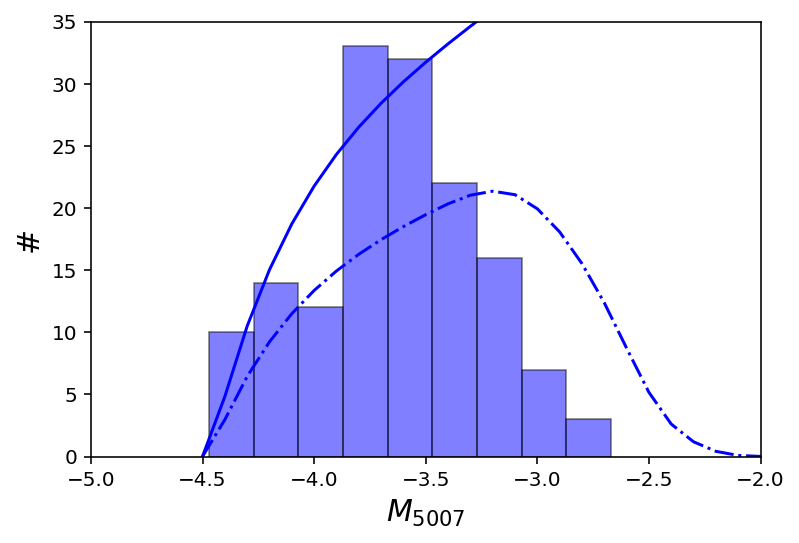

In [33]:
x_data_cen, y_data_cen, map_cen, aux = open_data(gal_name)

image, wave = reconstructed_image(gal_name)
image = image.reshape([y_data_cen,x_data_cen])

mag = PNe_df["M 5007"].loc[PNe_df["Filter"]=="Y"].values

# Total PNLF
PNLF, PNLF_corr, Abs_M = completeness(gal_name, mag, PNe_multi_params, 18.3, image, 2.5, mask=True ) # Estimating the completeness for the central pointing

# Getting the normalisation
total_norm = np.sum(PNLF_corr)*abs(Abs_M[1]-Abs_M[0])

# Scaling factor
scal = len(mag)/total_norm

# Constraining to -2.0 in magnitude
idx = np.where(Abs_M <= -2.0)
# Total number of PNe
tot_N_PNe = np.sum(PNLF_corr[idx]*scal)*abs(Abs_M[1]-Abs_M[0])

binwidth = 0.2
hist = plt.hist(mag, bins=np.arange(min(mag), max(mag) + binwidth, binwidth), edgecolor="black", linewidth=0.8, alpha=0.5, color='blue')

ymax = max(hist[0])

plt.plot(Abs_M, PNLF*scal*binwidth, '-', color='blue')
plt.plot(Abs_M, PNLF_corr*scal*binwidth,'-.', color='blue')

plt.xlabel(r'$M_{5007}$', fontsize=15); plt.ylabel(r'#', fontsize=15)
#plt.yticks(np.arange(0,ymax+4, 5))

plt.xlim(-5.0,-2.0); plt.ylim(0,ymax+2)

#plt.savefig("Plots/FCC167/PNLF.pdf")

In [32]:
stats.ks_2samp(np.histogram(PNLF_corr)[0], np.histogram(Abs_M)[0])

Ks_2sampResult(statistic=0.8, pvalue=0.0012162112998959323)

In [30]:
np.sum(PNLF_corr*scal*binwidth)

298.00000000000107525

In [40]:
np.sum(PNLF[idx]*scal)*abs(Abs_M[1]-Abs_M[0])

651.4733006153443